# CRRT Clot Formation Prediction Analysis
### Predicting visible clots in CRRT circuits using lab values within 6 hours prior
### WITH CLASS IMBALANCE HANDLING

**Updated Goal:** Predict visible clot formation (`clots=1`) rather than complete circuit failure.
This is more clinically actionable and has better class balance (10:1 vs 240:1).

**LLM Disclosure:** I used an LLM to write this code.

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, precision_recall_curve
)
from sklearn.impute import SimpleImputer

# For handling class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")
print("\nNote: If you get an import error for imblearn, install it with:")
print("  pip install imbalanced-learn")

✓ Libraries imported successfully

Note: If you get an import error for imblearn, install it with:
  pip install imbalanced-learn


In [3]:
! pip install gdown
import gdown
files = {
    "datasetv4.csv": "1C_jmIEtqAQYTiUKecbsUyqibR4jDSEZy"
}

for name, fid in files.items():
    url = f"https://drive.google.com/uc?id={fid}"
    gdown.download(url, name, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1C_jmIEtqAQYTiUKecbsUyqibR4jDSEZy
To: /content/datasetv4.csv
100%|██████████| 29.7M/29.7M [00:00<00:00, 96.0MB/s]


## 2. Load and Explore Data

In [4]:
# Load the filtered dataset (already filtered for clots IS NOT NULL)
df = pd.read_csv('datasetv4.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (125611, 64)

First few rows:


,subject_id,hadm_id,stay_id,charttime,crrt_mode,access_pressure,blood_flow,citrate,current_goal,dialysate_fluid,...,pco2,bicarbonate_1,triglyceride,hdl_cholesterol,ldl_cholesterol,ldl_source,magnesium,phosphate,antithrombin,ldh
0,11440929,23071615,30003749,2180-06-07 02:13:00,CVVHDF,-106.0,250.0,200.0,0.0,Prismasate K2,...,28.0,NaN,NaN,NaN,NaN,NaN,2.2,10.0,NaN,NaN
1,15850686,25593892,30005000,2117-12-07 08:00:00,NaN,-58.0,200.0,200.0,0.0,Prismasate K2,...,37.0,NaN,NaN,NaN,NaN,NaN,2.0,3.2,NaN,NaN
2,15850686,25593892,30005000,2117-12-05 20:11:00,CVVHDF,-68.0,200.0,100.0,0.0,Prismasate K2,...,38.0,NaN,179.0,NaN,NaN,NaN,2.4,4.6,NaN,NaN
3,15850686,25593892,30005000,2117-12-06 10:00:00,NaN,-66.0,200.0,200.0,-25.0,Prismasate K2,...,35.0,NaN,NaN,NaN,NaN,NaN,2.1,3.7,NaN,NaN
4,15850686,25593892,30005000,2117-12-06 08:00:00,NaN,-68.0,200.0,200.0,-50.0,Prismasate K2,...,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Verify the filtered dataset
print("="*70)
print("DATASET VERIFICATION")
print("="*70)
print(f"Total observations: {len(df):,}")
print(f"\nClots column distribution (our TARGET):")
print(df['clots'].value_counts(dropna=False))
print(f"\nMissing clots: {df['clots'].isnull().sum():,}")
print(f"This should be 0 after BigQuery filtering!")

print(f"\n{'='*70}")
print("Note: We're predicting VISIBLE CLOTS (clots=1)")
print("NOT complete circuit failure (clotted=1)")
print("This is more predictable and clinically actionable!")
print("="*70)

DATASET VERIFICATION
Total observations: 125,611

Clots column distribution (our TARGET):
clots
1    113622
0     11989
Name: count, dtype: int64

Missing clots: 0
This should be 0 after BigQuery filtering!

Note: We're predicting VISIBLE CLOTS (clots=1)
NOT complete circuit failure (clotted=1)
This is more predictable and clinically actionable!


In [6]:
# Basic data summary
print("=" * 60)
print("DATA SUMMARY")
print("=" * 60)
print(f"Total observations: {len(df):,}")
print(f"Unique patients (subject_id): {df['subject_id'].nunique():,}")
print(f"Unique hospital admissions (hadm_id): {df['hadm_id'].nunique():,}")
print(f"Unique ICU stays (stay_id): {df['stay_id'].nunique():,}")

# Check target variable distribution
print(f"\n{'='*60}")
print("TARGET VARIABLE: clots (visible clots in circuit)")
print("=" * 60)
print(df['clots'].value_counts())
print(f"\nObservation-level clots rate: {df['clots'].mean()*100:.2f}%")
print(f"Class imbalance ratio: {(df['clots']==0).sum() / (df['clots']==1).sum():.1f}:1")
print("\n(Much better than the 240:1 ratio when predicting circuit failure!)")

DATA SUMMARY
Total observations: 125,611
Unique patients (subject_id): 1,971
Unique hospital admissions (hadm_id): 2,063
Unique ICU stays (stay_id): 2,137

TARGET VARIABLE: clots (visible clots in circuit)
clots
1    113622
0     11989
Name: count, dtype: int64

Observation-level clots rate: 90.46%
Class imbalance ratio: 0.1:1

(Much better than the 240:1 ratio when predicting circuit failure!)


EXPLORATORY DATA ANALYSIS

SUMMARY STATISTICS - CONTINUOUS VARIABLES

Analyzing 44 continuous variables


LAB VALUES
    Variable      N        Mean  Median     Std Dev
  hematocrit  65850   27.055336   26.40    4.187258
  hemoglobin  61077    8.849434    8.60    1.428271
    platelet  62322  133.786178  100.00  108.255337
         rbc  59984    2.901880    2.82    0.510130
         wbc  59858   17.110271   15.10   10.945263
     d_dimer    931 5648.062299 4726.00 4911.671085
  fibrinogen  15062  309.616784  207.00  232.721276
    thrombin     81   26.574074   15.80   29.709034
         inr  49368    1.747874    1.50    0.959594
          pt  49396   18.939337   16.00    9.332323
         ptt  55003   50.220044   43.20   23.501939
     albumin  12650    2.916964    2.80    0.791639
         bun  85708   28.122824   24.00   18.928711
     calcium  84388    9.045037    9.00    0.940969
  creatinine  85834    1.809353    1.50    1.199731
     glucose 101577  154.543430  143.00   54.742451

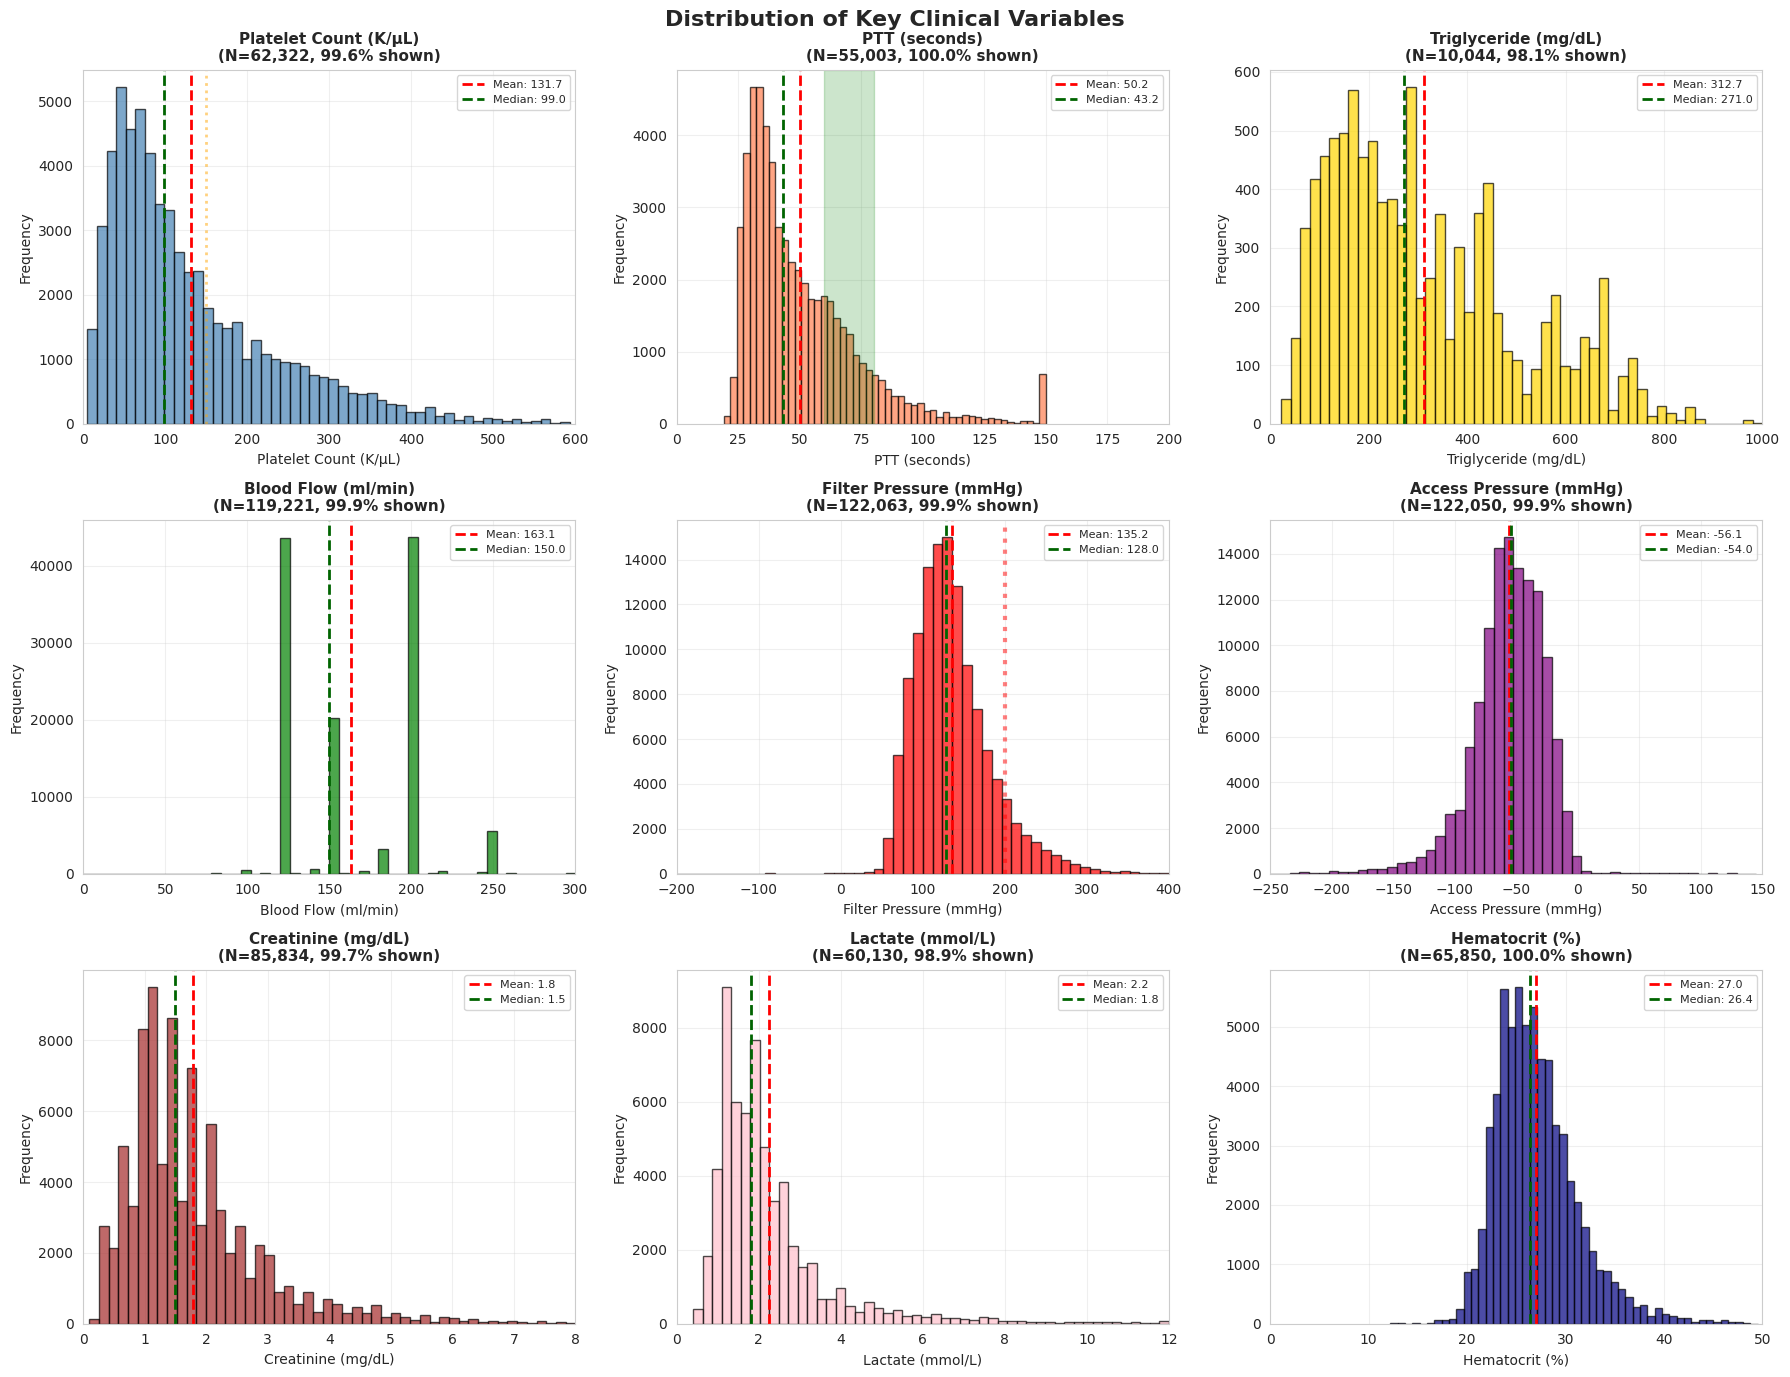

✓ Figure 1 (improved) saved: exploratory_distributions_improved.png

OUTLIER ANALYSIS

Percentage of extreme outliers (beyond 99th percentile):

platelet            :    619 ( 0.99%) above 491.0
ptt                 :      0 ( 0.00%) above 150.0
triglyceride        :    100 ( 1.00%) above 1140.0
blood_flow          :    248 ( 0.21%) above 250.0
filter_pressure     :  1,207 ( 0.99%) above 286.0
creatinine          :    812 ( 0.95%) above 6.3
lactate             :    597 ( 0.99%) above 12.4

Creating correlation heatmap...


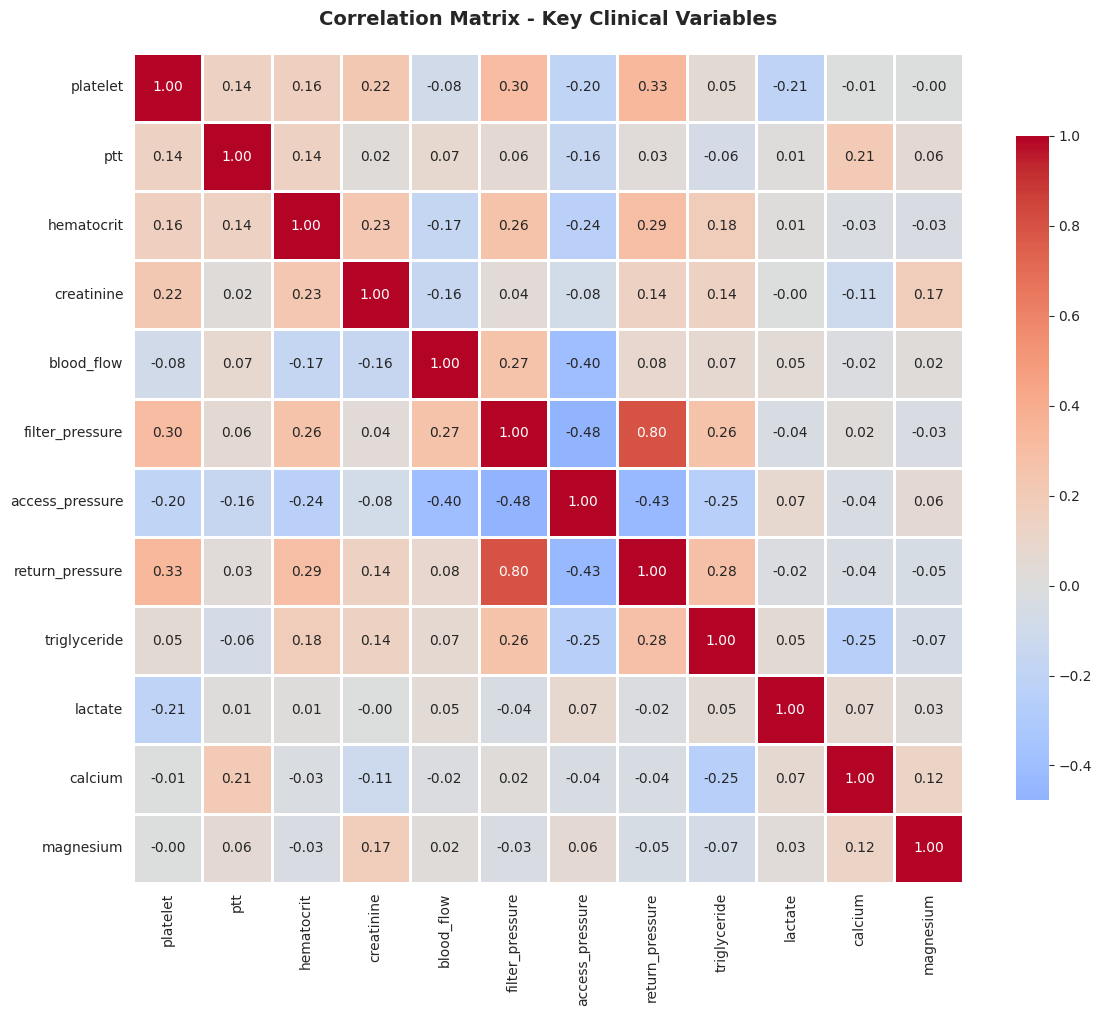

✓ Figure 2 saved: correlation_heatmap.png

Creating improved box plots by outcome...


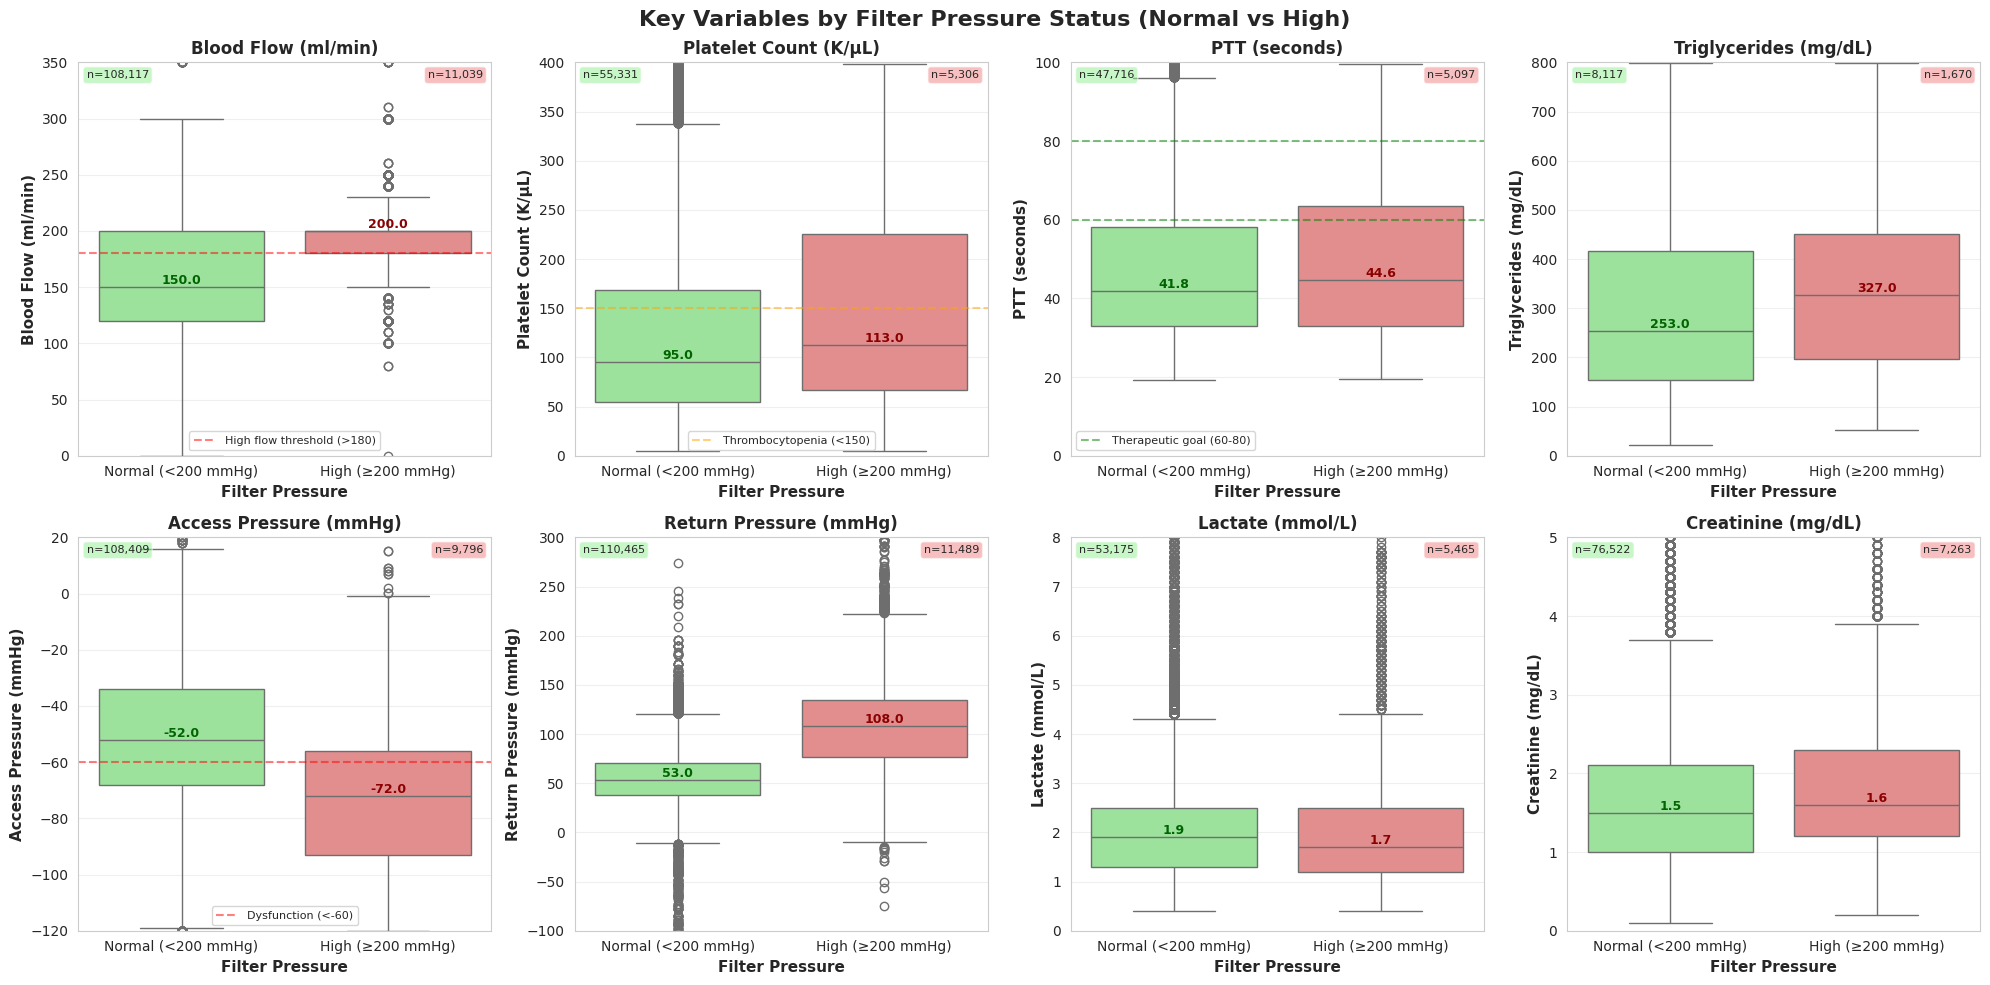

✓ Figure 3 (improved) saved: boxplots_by_outcome_improved.png

COMPARISON: NORMAL vs HIGH FILTER PRESSURE

               Variable  Normal_Median  High_Median  Difference  Normal_Mean  High_Mean
   Blood Flow (ml/min)          150.0        200.0        50.0   160.216478 192.364798
 Platelet Count (K/µL)           95.0        113.0        18.0   121.464101 147.171315
         PTT (seconds)           41.8         44.6         2.8    46.787143  49.509692
 Triglycerides (mg/dL)          253.0        327.0        74.0   299.188493 355.467066
Access Pressure (mmHg)          -52.0        -72.0       -20.0   -52.075961 -73.065986
Return Pressure (mmHg)           53.0        108.0        55.0    55.649799 109.391713
      Lactate (mmol/L)            1.9          1.7        -0.2     2.151885   2.060567
    Creatinine (mg/dL)            1.5          1.6         0.1     1.679198   1.853490

Creating improved scatter plots...


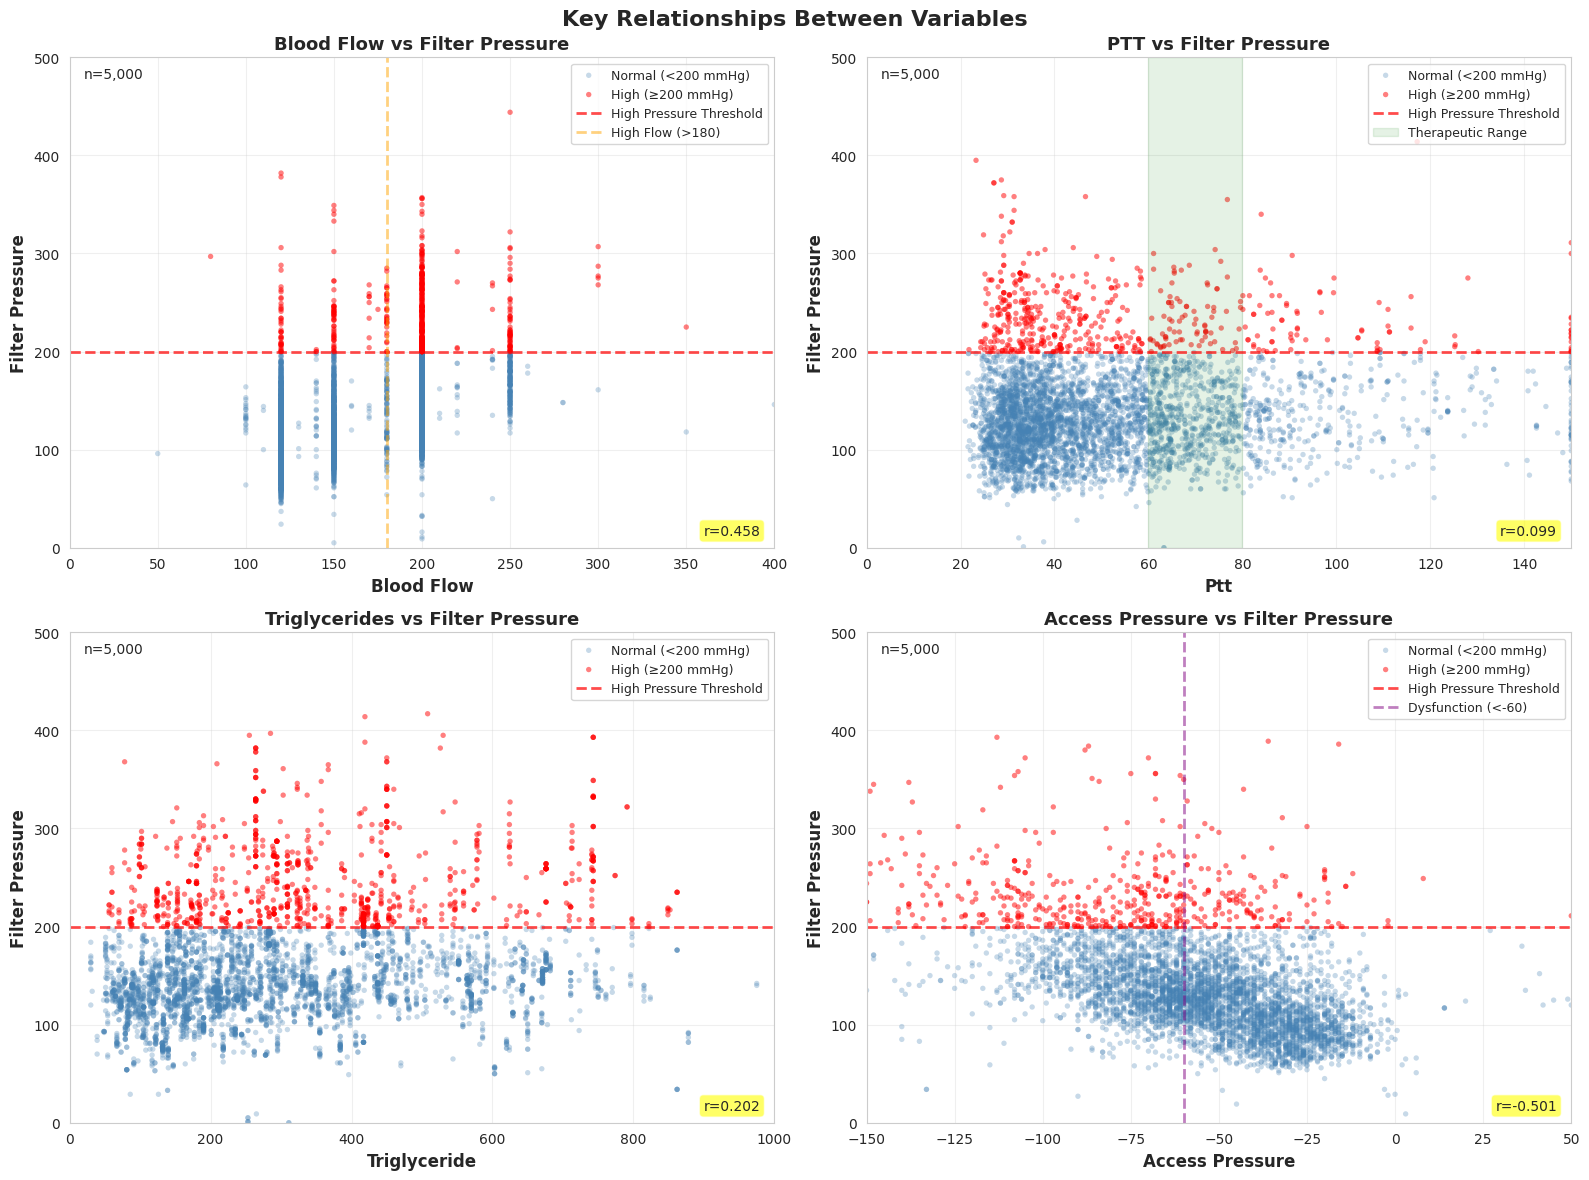

✓ Figure 4 (improved) saved: scatter_plots_improved.png

Creating additional diagnostic scatter plot...


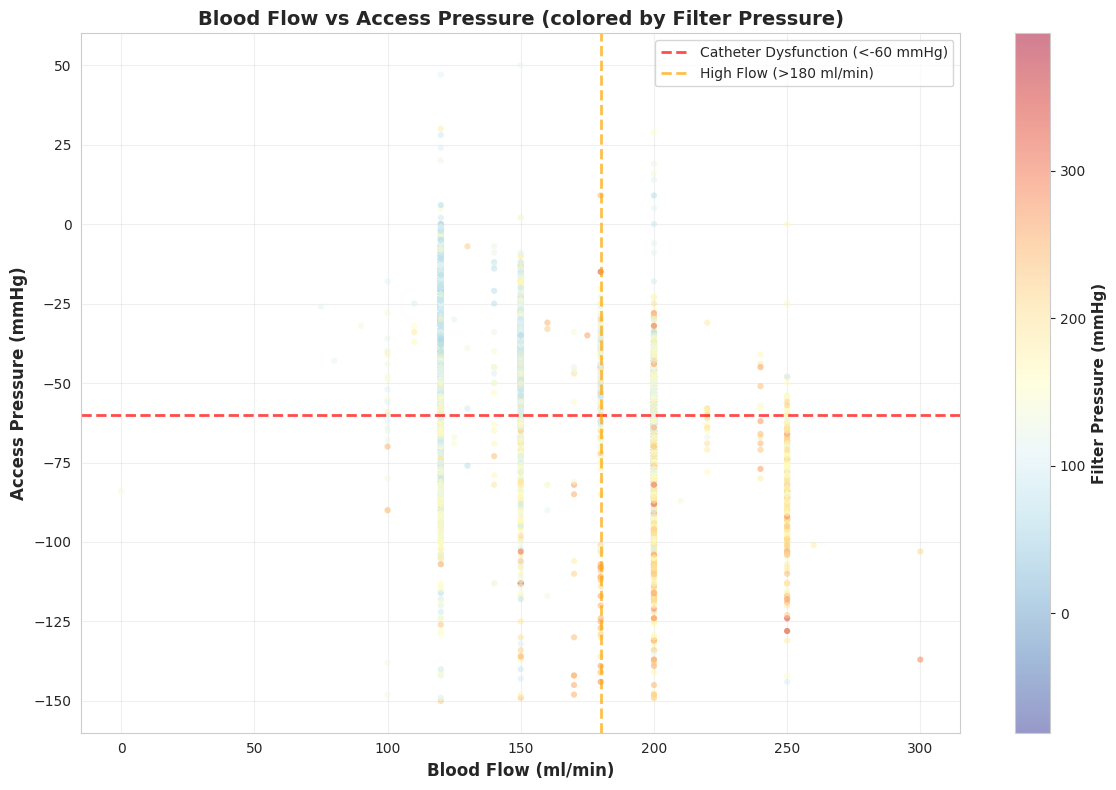

✓ Bonus figure saved: blood_flow_vs_access_pressure.png

MISSING DATA ANALYSIS

Variables with Missing Data (Top 20):
       Variable  Missing Count  Missing %
   antithrombin         125611 100.000000
       globulin         125549  99.950641
       thrombin         125530  99.935515
  total_protein         125435  99.859885
ldl_cholesterol         125292  99.746041
hdl_cholesterol         125126  99.613887
        d_dimer         124680  99.258823
   triglyceride         115567  92.003885
        albumin         112961  89.929226
     fibrinogen         110549  88.009012
            inr          76243  60.697710
             pt          76215  60.675419
            ldh          74317  59.164404
            ptt          70608  56.211638
            wbc          65753  52.346530
            rbc          65627  52.246220
        lactate          65481  52.129989
     hemoglobin          64534  51.376074
       platelet          63289  50.384919
     hematocrit          59761  47.576247


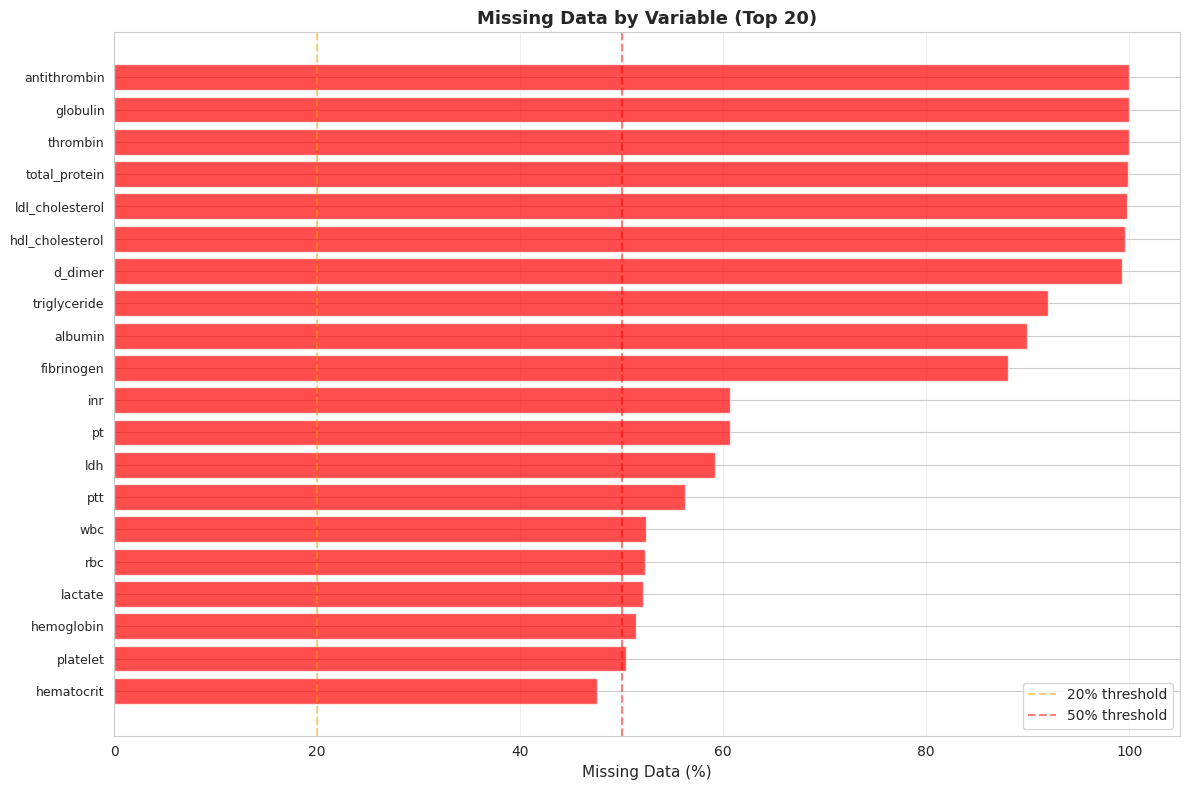


✓ Figure 5 saved: missing_data_analysis.png

✓ EXPLORATORY DATA ANALYSIS COMPLETE

Generated files:
  1. summary_statistics.csv - Complete summary statistics
  2. exploratory_distributions.png - Distribution plots
  3. correlation_heatmap.png - Correlation matrix
  4. boxplots_by_outcome.png - Box plots by outcome
  5. scatter_plots.png - Key relationships
  6. missing_data_analysis.png - Missing data visualization


In [41]:
print("="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

# ================================================================
# SUMMARY STATISTICS FOR ALL CONTINUOUS VARIABLES
# ================================================================

print("\n" + "="*70)
print("SUMMARY STATISTICS - CONTINUOUS VARIABLES")
print("="*70)

# Define all continuous variables
continuous_vars = [
    # Lab values
    'hematocrit', 'hemoglobin', 'platelet', 'rbc', 'wbc',
    'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt',
    'albumin', 'globulin', 'total_protein', 'aniongap', 'bicarbonate',
    'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium',
    'lactate', 'ph', 'bg_bicarbonate', 'pco2',
    'triglyceride', 'hdl_cholesterol', 'ldl_cholesterol',
    'magnesium', 'phosphate', 'antithrombin', 'ldh',
    # Machine parameters
    'blood_flow', 'filter_pressure', 'access_pressure', 'return_pressure',
    'dialysate_rate', 'replacement_rate', 'ultrafiltrate_output',
    'effluent_pressure', 'hourly_patient_fluid_removal',
    # Anticoagulation
    'citrate', 'heparin_dose'
]

# Filter to variables that exist in the dataset
available_continuous = [var for var in continuous_vars if var in df.columns]

print(f"\nAnalyzing {len(available_continuous)} continuous variables\n")

# Calculate summary statistics
summary_stats = []
for var in available_continuous:
    data = df[var].dropna()

    if len(data) > 0:
        summary_stats.append({
            'Variable': var,
            'N': len(data),
            'Missing': df[var].isna().sum(),
            'Missing %': (df[var].isna().sum() / len(df) * 100),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            '25th': data.quantile(0.25),
            '75th': data.quantile(0.75)
        })

summary_df = pd.DataFrame(summary_stats)

# Display by category
print("\n" + "="*70)
print("LAB VALUES")
print("="*70)
lab_vars = ['hematocrit', 'hemoglobin', 'platelet', 'rbc', 'wbc',
            'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt',
            'albumin', 'bun', 'calcium', 'creatinine', 'glucose', 'sodium',
            'potassium', 'lactate', 'ph', 'triglyceride', 'magnesium', 'phosphate']
lab_summary = summary_df[summary_df['Variable'].isin(lab_vars)]
print(lab_summary[['Variable', 'N', 'Mean', 'Median', 'Std Dev']].to_string(index=False))

print("\n" + "="*70)
print("MACHINE PARAMETERS")
print("="*70)
machine_vars = ['blood_flow', 'filter_pressure', 'access_pressure', 'return_pressure',
                'dialysate_rate', 'replacement_rate', 'ultrafiltrate_output', 'effluent_pressure']
machine_summary = summary_df[summary_df['Variable'].isin(machine_vars)]
print(machine_summary[['Variable', 'N', 'Mean', 'Median', 'Std Dev']].to_string(index=False))

# Save full summary to CSV
summary_df.to_csv('summary_statistics.csv', index=False)
print(f"\n✓ Full summary statistics saved to 'summary_statistics.csv'")

# ================================================================
# EXPLORATORY DATA VISUALIZATIONS
# ================================================================

print("\n" + "="*70)
print("CREATING EXPLORATORY VISUALIZATIONS")
print("="*70)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

# ----------------------------------------------------------------
# FIGURE 1: Distribution of Key Variables
# ----------------------------------------------------------------

# ----------------------------------------------------------------
# FIGURE 1: Distribution of Key Variables (IMPROVED)
# ----------------------------------------------------------------

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of Key Clinical Variables', fontsize=16, fontweight='bold')

key_vars = [
    ('platelet', 'Platelet Count (K/µL)', 'steelblue', (0, 600)),  # Cut off extreme outliers
    ('ptt', 'PTT (seconds)', 'coral', (0, 200)),  # Focus on clinically relevant range
    ('triglyceride', 'Triglyceride (mg/dL)', 'gold', (0, 1000)),  # Cut off extremes
    ('blood_flow', 'Blood Flow (ml/min)', 'green', (0, 300)),  # Focus on main distribution
    ('filter_pressure', 'Filter Pressure (mmHg)', 'red', (-200, 400)),  # Cut off outliers
    ('access_pressure', 'Access Pressure (mmHg)', 'purple', (-250, 150)),  # Should be negative
    ('creatinine', 'Creatinine (mg/dL)', 'brown', (0, 8)),  # Focus on relevant range
    ('lactate', 'Lactate (mmol/L)', 'pink', (0, 12)),  # Cut off extremes
    ('hematocrit', 'Hematocrit (%)', 'navy', (0, 50))  # Physiologic range
]

for idx, (var, title, color, xlim) in enumerate(key_vars):
    ax = axes[idx // 3, idx % 3]
    if var in df.columns:
        data = df[var].dropna()

        # Filter data to reasonable range for better visualization
        data_filtered = data[(data >= xlim[0]) & (data <= xlim[1])]

        if len(data_filtered) > 0:
            ax.hist(data_filtered, bins=50, edgecolor='black', alpha=0.7, color=color)

            # Add mean and median lines
            mean_val = data_filtered.mean()
            median_val = data_filtered.median()
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {mean_val:.1f}')
            ax.axvline(median_val, color='darkgreen', linestyle='--', linewidth=2,
                      label=f'Median: {median_val:.1f}')

            # Set labels and limits
            ax.set_xlabel(title, fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.set_xlim(xlim)

            # Show percentage of data included
            pct_included = (len(data_filtered) / len(data)) * 100
            ax.set_title(f'{title}\n(N={len(data):,}, {pct_included:.1f}% shown)',
                        fontsize=11, fontweight='bold')

            ax.legend(fontsize=8, loc='upper right')
            ax.grid(True, alpha=0.3)

            # Add reference lines for clinically important values
            if var == 'filter_pressure':
                ax.axvline(200, color='red', linestyle=':', linewidth=3,
                          label='High Pressure (≥200)', alpha=0.5)
            elif var == 'ptt':
                ax.axvspan(60, 80, alpha=0.2, color='green', label='Therapeutic Range')
            elif var == 'platelet':
                ax.axvline(150, color='orange', linestyle=':', linewidth=2,
                          label='Low (<150)', alpha=0.5)

    else:
        ax.text(0.5, 0.5, f'{var}\nNot Available', ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig('exploratory_distributions_improved.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 1 (improved) saved: exploratory_distributions_improved.png")

# ----------------------------------------------------------------
# ADDITIONAL: Show outlier information
# ----------------------------------------------------------------

print("\n" + "="*70)
print("OUTLIER ANALYSIS")
print("="*70)

outlier_vars = ['platelet', 'ptt', 'triglyceride', 'blood_flow', 'filter_pressure',
                'creatinine', 'lactate']

print("\nPercentage of extreme outliers (beyond 99th percentile):\n")
for var in outlier_vars:
    if var in df.columns:
        data = df[var].dropna()
        p99 = data.quantile(0.99)
        outliers = (data > p99).sum()
        pct = (outliers / len(data)) * 100
        print(f"{var:20s}: {outliers:6,} ({pct:5.2f}%) above {p99:.1f}")

# ----------------------------------------------------------------
# FIGURE 2: Correlation Heatmap
# ----------------------------------------------------------------

print("\nCreating correlation heatmap...")

# Select numeric columns for correlation
numeric_cols = ['platelet', 'ptt', 'hematocrit', 'creatinine', 'blood_flow',
                'filter_pressure', 'access_pressure', 'return_pressure',
                'triglyceride', 'lactate', 'calcium', 'magnesium']

available_numeric = [col for col in numeric_cols if col in df.columns]
corr_data = df[available_numeric].dropna()

if len(corr_data) > 100:
    correlation_matrix = corr_data.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Key Clinical Variables', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Figure 2 saved: correlation_heatmap.png")
else:
    print("⚠ Insufficient data for correlation matrix")

# ----------------------------------------------------------------
# FIGURE 3: Box Plots by Outcome
# ----------------------------------------------------------------

# ----------------------------------------------------------------
# FIGURE 3: Box Plots by Outcome (IMPROVED)
# ----------------------------------------------------------------

print("\nCreating improved box plots by outcome...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Key Variables by Filter Pressure Status (Normal vs High)', fontsize=16, fontweight='bold')

# Create outcome variable for visualization
df['high_pressure'] = (df['filter_pressure'] >= 200).astype(int)

# Define variables with better y-axis limits and outlier handling
boxplot_vars = [
    ('blood_flow', 'Blood Flow (ml/min)', (0, 350)),
    ('platelet', 'Platelet Count (K/µL)', (0, 400)),
    ('ptt', 'PTT (seconds)', (0, 100)),
    ('triglyceride', 'Triglycerides (mg/dL)', (0, 800)),
    ('access_pressure', 'Access Pressure (mmHg)', (-120, 20)),
    ('return_pressure', 'Return Pressure (mmHg)', (-100, 300)),
    ('lactate', 'Lactate (mmol/L)', (0, 8)),
    ('creatinine', 'Creatinine (mg/dL)', (0, 5))
]

for idx, (var, title, ylim) in enumerate(boxplot_vars):
    ax = axes[idx // 4, idx % 4]
    if var in df.columns:
        # Filter data to remove extreme outliers
        data_to_plot = df[[var, 'high_pressure']].dropna()
        data_to_plot = data_to_plot[(data_to_plot[var] >= ylim[0]) &
                                     (data_to_plot[var] <= ylim[1])]

        if len(data_to_plot) > 0:
            # Create boxplot
            sns.boxplot(data=data_to_plot, x='high_pressure', y=var, ax=ax,
                       palette=['lightgreen', 'lightcoral'], showfliers=True)

            # Set labels
            ax.set_xlabel('Filter Pressure', fontsize=11, fontweight='bold')
            ax.set_xticklabels(['Normal (<200 mmHg)', 'High (≥200 mmHg)'], fontsize=10)
            ax.set_ylabel(title, fontsize=11, fontweight='bold')
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_ylim(ylim)
            ax.grid(True, alpha=0.3, axis='y')

            # Calculate and display statistics
            normal_vals = data_to_plot[data_to_plot['high_pressure']==0][var]
            high_vals = data_to_plot[data_to_plot['high_pressure']==1][var]

            if len(normal_vals) > 0 and len(high_vals) > 0:
                normal_median = normal_vals.median()
                high_median = high_vals.median()

                # Add median values as text
                ax.text(0, normal_median, f'{normal_median:.1f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkgreen')
                ax.text(1, high_median, f'{high_median:.1f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

                # Add reference lines for clinical thresholds
                if var == 'ptt':
                    ax.axhline(y=60, color='green', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='Therapeutic goal (60-80)')
                    ax.axhline(y=80, color='green', linestyle='--', linewidth=1.5, alpha=0.5)
                    ax.legend(fontsize=8)
                elif var == 'platelet':
                    ax.axhline(y=150, color='orange', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='Thrombocytopenia (<150)')
                    ax.legend(fontsize=8)
                elif var == 'blood_flow':
                    ax.axhline(y=180, color='red', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='High flow threshold (>180)')
                    ax.legend(fontsize=8)
                elif var == 'access_pressure':
                    ax.axhline(y=-60, color='red', linestyle='--', linewidth=1.5,
                              alpha=0.5, label='Dysfunction (<-60)')
                    ax.legend(fontsize=8)

            # Show sample sizes
            n_normal = len(normal_vals)
            n_high = len(high_vals)
            ax.text(0.02, 0.98, f'n={n_normal:,}', transform=ax.transAxes,
                   fontsize=8, va='top', ha='left', bbox=dict(boxstyle='round',
                   facecolor='lightgreen', alpha=0.5))
            ax.text(0.98, 0.98, f'n={n_high:,}', transform=ax.transAxes,
                   fontsize=8, va='top', ha='right', bbox=dict(boxstyle='round',
                   facecolor='lightcoral', alpha=0.5))
    else:
        ax.text(0.5, 0.5, f'{var}\nNot Available', ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig('boxplots_by_outcome_improved.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 3 (improved) saved: boxplots_by_outcome_improved.png")

# ----------------------------------------------------------------
# Print comparison statistics
# ----------------------------------------------------------------

print("\n" + "="*70)
print("COMPARISON: NORMAL vs HIGH FILTER PRESSURE")
print("="*70)

comparison_results = []
for var, title, ylim in boxplot_vars:
    if var in df.columns:
        normal_vals = df[df['high_pressure']==0][var].dropna()
        high_vals = df[df['high_pressure']==1][var].dropna()

        # Filter to reasonable range
        normal_vals = normal_vals[(normal_vals >= ylim[0]) & (normal_vals <= ylim[1])]
        high_vals = high_vals[(high_vals >= ylim[0]) & (high_vals <= ylim[1])]

        if len(normal_vals) > 0 and len(high_vals) > 0:
            comparison_results.append({
                'Variable': title,
                'Normal_Median': normal_vals.median(),
                'High_Median': high_vals.median(),
                'Difference': high_vals.median() - normal_vals.median(),
                'Normal_Mean': normal_vals.mean(),
                'High_Mean': high_vals.mean()
            })

comparison_df = pd.DataFrame(comparison_results)
print("\n", comparison_df.to_string(index=False))

# ----------------------------------------------------------------
# FIGURE 4: Scatter Plots - Key Relationships
# ----------------------------------------------------------------

# ----------------------------------------------------------------
# FIGURE 4: Scatter Plots - Key Relationships (IMPROVED)
# ----------------------------------------------------------------

print("\nCreating improved scatter plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Key Relationships Between Variables', fontsize=16, fontweight='bold')

# Define scatter pairs with appropriate axis limits
scatter_pairs = [
    ('blood_flow', 'filter_pressure', 'Blood Flow vs Filter Pressure',
     (0, 400), (0, 500)),
    ('ptt', 'filter_pressure', 'PTT vs Filter Pressure',
     (0, 150), (0, 500)),
    ('triglyceride', 'filter_pressure', 'Triglycerides vs Filter Pressure',
     (0, 1000), (0, 500)),
    ('access_pressure', 'filter_pressure', 'Access Pressure vs Filter Pressure',
     (-150, 50), (0, 500))
]

for idx, (x_var, y_var, title, xlim, ylim) in enumerate(scatter_pairs):
    ax = axes[idx // 2, idx % 2]
    if x_var in df.columns and y_var in df.columns:
        # Filter data to remove outliers
        plot_data = df[[x_var, y_var]].dropna()
        plot_data = plot_data[
            (plot_data[x_var] >= xlim[0]) & (plot_data[x_var] <= xlim[1]) &
            (plot_data[y_var] >= ylim[0]) & (plot_data[y_var] <= ylim[1])
        ]

        # Sample if too many points (for performance)
        if len(plot_data) > 5000:
            plot_data = plot_data.sample(5000, random_state=42)

        if len(plot_data) > 0:
            # Create scatter plot with color based on high pressure
            plot_data['high_pressure'] = (plot_data[y_var] >= 200).astype(int)

            # Plot normal pressure in blue, high pressure in red
            normal = plot_data[plot_data['high_pressure'] == 0]
            high = plot_data[plot_data['high_pressure'] == 1]

            ax.scatter(normal[x_var], normal[y_var], alpha=0.3, s=15,
                      c='steelblue', label='Normal (<200 mmHg)', edgecolors='none')
            ax.scatter(high[x_var], high[y_var], alpha=0.5, s=15,
                      c='red', label='High (≥200 mmHg)', edgecolors='none')

            # Add horizontal line at high pressure threshold
            ax.axhline(y=200, color='red', linestyle='--', linewidth=2,
                      label='High Pressure Threshold', alpha=0.7)

            # Add vertical reference lines for specific variables
            if x_var == 'blood_flow':
                ax.axvline(x=180, color='orange', linestyle='--', linewidth=2,
                          label='High Flow (>180)', alpha=0.5)
            elif x_var == 'ptt':
                ax.axvspan(60, 80, alpha=0.1, color='green', label='Therapeutic Range')
            elif x_var == 'access_pressure':
                ax.axvline(x=-60, color='purple', linestyle='--', linewidth=2,
                          label='Dysfunction (<-60)', alpha=0.5)

            # Set labels and limits
            ax.set_xlabel(x_var.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            ax.set_ylabel(y_var.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            ax.set_title(title, fontsize=13, fontweight='bold')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.legend(fontsize=9, loc='best')
            ax.grid(True, alpha=0.3)

            # Add sample size
            ax.text(0.02, 0.98, f'n={len(plot_data):,}',
                   transform=ax.transAxes, fontsize=10, va='top', ha='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Calculate and display correlation
            corr = plot_data[x_var].corr(plot_data[y_var])
            ax.text(0.98, 0.02, f'r={corr:.3f}',
                   transform=ax.transAxes, fontsize=10, va='bottom', ha='right',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))
    else:
        ax.text(0.5, 0.5, f'Data not available', ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig('scatter_plots_improved.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Figure 4 (improved) saved: scatter_plots_improved.png")

# ----------------------------------------------------------------
# Additional scatter plot: Blood Flow vs Access Pressure (colored by outcome)
# ----------------------------------------------------------------

print("\nCreating additional diagnostic scatter plot...")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

if 'blood_flow' in df.columns and 'access_pressure' in df.columns:
    plot_data = df[['blood_flow', 'access_pressure', 'filter_pressure']].dropna()
    plot_data = plot_data[
        (plot_data['blood_flow'] >= 0) & (plot_data['blood_flow'] <= 400) &
        (plot_data['access_pressure'] >= -150) & (plot_data['access_pressure'] <= 50)
    ]

    if len(plot_data) > 5000:
        plot_data = plot_data.sample(5000, random_state=42)

    # Color by filter pressure
    scatter = ax.scatter(plot_data['blood_flow'], plot_data['access_pressure'],
                        c=plot_data['filter_pressure'], cmap='RdYlBu_r',
                        alpha=0.5, s=20, edgecolors='none')

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Filter Pressure (mmHg)', fontsize=11, fontweight='bold')

    # Add reference lines
    ax.axhline(y=-60, color='red', linestyle='--', linewidth=2,
              label='Catheter Dysfunction (<-60 mmHg)', alpha=0.7)
    ax.axvline(x=180, color='orange', linestyle='--', linewidth=2,
              label='High Flow (>180 ml/min)', alpha=0.7)

    # Labels
    ax.set_xlabel('Blood Flow (ml/min)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Access Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Flow vs Access Pressure (colored by Filter Pressure)',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('blood_flow_vs_access_pressure.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Bonus figure saved: blood_flow_vs_access_pressure.png")

# ----------------------------------------------------------------
# MISSING DATA ANALYSIS
# ----------------------------------------------------------------

print("\n" + "="*70)
print("MISSING DATA ANALYSIS")
print("="*70)

missing_summary = []
for col in available_continuous:
    missing_count = df[col].isna().sum()
    missing_pct = (missing_count / len(df)) * 100
    if missing_count > 0:
        missing_summary.append({
            'Variable': col,
            'Missing Count': missing_count,
            'Missing %': missing_pct
        })

missing_df = pd.DataFrame(missing_summary).sort_values('Missing %', ascending=False)

print("\nVariables with Missing Data (Top 20):")
print(missing_df.head(20).to_string(index=False))

# Visualize missing data
if len(missing_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top_missing = missing_df.head(20).sort_values('Missing %')
    colors = ['red']
    ax.barh(range(len(top_missing)), top_missing['Missing %'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_missing)))
    ax.set_yticklabels(top_missing['Variable'], fontsize=9)
    ax.set_xlabel('Missing Data (%)', fontsize=11)
    ax.set_title('Missing Data by Variable (Top 20)', fontsize=13, fontweight='bold')
    ax.axvline(x=20, color='orange', linestyle='--', alpha=0.5, label='20% threshold')
    ax.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('missing_data_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Figure 5 saved: missing_data_analysis.png")

print("\n" + "="*70)
print("✓ EXPLORATORY DATA ANALYSIS COMPLETE")
print("="*70)
print(f"\nGenerated files:")
print("  1. summary_statistics.csv - Complete summary statistics")
print("  2. exploratory_distributions.png - Distribution plots")
print("  3. correlation_heatmap.png - Correlation matrix")
print("  4. boxplots_by_outcome.png - Box plots by outcome")
print("  5. scatter_plots.png - Key relationships")
print("  6. missing_data_analysis.png - Missing data visualization")

PATIENT-LEVEL CLOTS ANALYSIS

Total unique patients: 1,971

Patients who had visible clots: 1,791
Patients who never had clots: 180

Proportion of patients with clots: 90.87%

------------------------------------------------------------
Distribution of clots observations per patient (among those with clots):
count    1791.000000
mean       63.440536
std       150.819514
min         1.000000
25%         8.000000
50%        24.000000
75%        65.000000
max      2803.000000
Name: num_clots_observations, dtype: float64


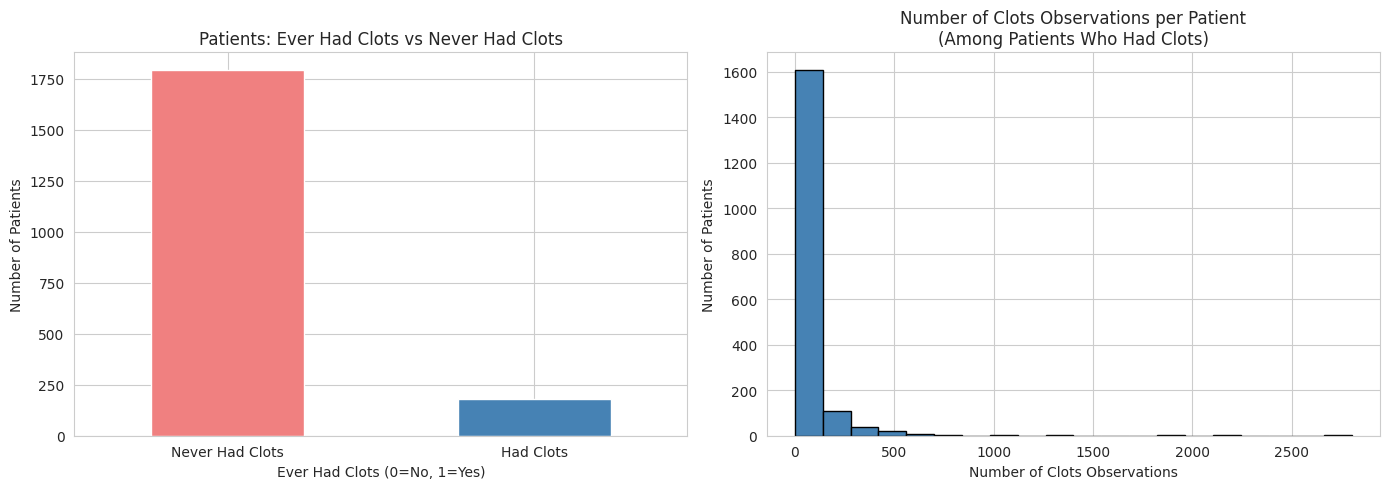

In [7]:
# Patient-level clots analysis
print("=" * 60)
print("PATIENT-LEVEL CLOTS ANALYSIS")
print("=" * 60)

# For each patient, check if they had visible clots
patient_clots = df.groupby('subject_id')['clots'].agg(['max', 'sum', 'count'])
patient_clots.columns = ['ever_had_clots', 'num_clots_observations', 'total_observations']

print(f"\nTotal unique patients: {len(patient_clots):,}")
print(f"\nPatients who had visible clots: {(patient_clots['ever_had_clots'] == 1).sum():,}")
print(f"Patients who never had clots: {(patient_clots['ever_had_clots'] == 0).sum():,}")
print(f"\nProportion of patients with clots: {(patient_clots['ever_had_clots'] == 1).mean()*100:.2f}%")

print("\n" + "-" * 60)
print("Distribution of clots observations per patient (among those with clots):")
print(patient_clots[patient_clots['ever_had_clots'] == 1]['num_clots_observations'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Patient-level clots
patient_clots['ever_had_clots'].value_counts().plot(kind='bar', ax=axes[0], color=['lightcoral', 'steelblue'])
axes[0].set_title('Patients: Ever Had Clots vs Never Had Clots')
axes[0].set_xlabel('Ever Had Clots (0=No, 1=Yes)')
axes[0].set_ylabel('Number of Patients')
axes[0].set_xticklabels(['Never Had Clots', 'Had Clots'], rotation=0)

# Distribution of clots observations among patients who had clots
clots_patients = patient_clots[patient_clots['ever_had_clots'] == 1]
clots_patients['num_clots_observations'].hist(bins=20, ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Number of Clots Observations per Patient\n(Among Patients Who Had Clots)')
axes[1].set_xlabel('Number of Clots Observations')
axes[1].set_ylabel('Number of Patients')

plt.tight_layout()
plt.show()

MISSING DATA ANALYSIS

Columns with missing data:
antithrombin                  : 100.00% missing
globulin                      :  99.95% missing
thrombin                      :  99.94% missing
clotted                       :  99.87% missing
total_protein                 :  99.86% missing
bicarbonate_1                 :  99.75% missing
ldl_cholesterol               :  99.75% missing
hdl_cholesterol               :  99.61% missing
ldl_source                    :  99.52% missing
d_dimer                       :  99.26% missing
clots_increasing              :  98.32% missing
triglyceride                  :  92.00% missing
heparin_concentration         :  91.58% missing
albumin                       :  89.93% missing
fibrinogen                    :  88.01% missing
inr                           :  60.70% missing
pt                            :  60.68% missing
ldh                           :  59.16% missing
ptt                           :  56.21% missing
line_site                     :  53.35

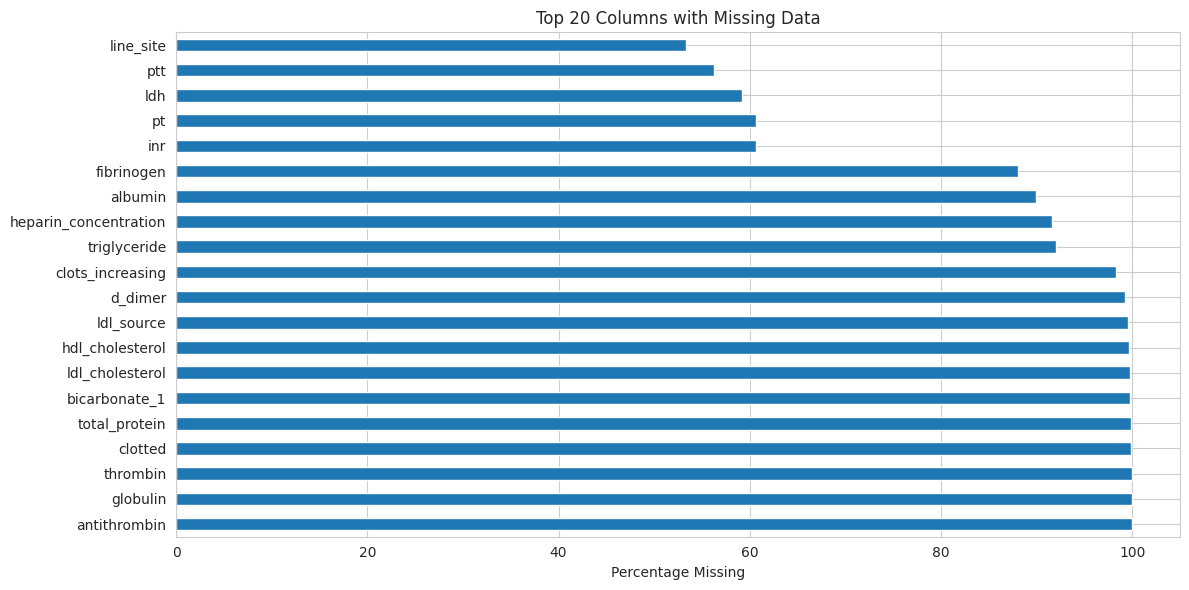

In [8]:
# Check for missing data
print("=" * 60)
print("MISSING DATA ANALYSIS")
print("=" * 60)

missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

if len(missing_pct) > 0:
    print(f"\nColumns with missing data:")
    for col, pct in missing_pct.head(20).items():
        print(f"{col:30s}: {pct:6.2f}% missing")

    # Visualize missing data
    plt.figure(figsize=(12, 6))
    missing_pct[:20].plot(kind='barh')
    plt.xlabel('Percentage Missing')
    plt.title('Top 20 Columns with Missing Data')
    plt.tight_layout()
    plt.show()
else:
    print("No missing data found!")

## 3. Data Preprocessing

In [9]:
# Define feature groups for better organization
id_cols = ['subject_id', 'hadm_id', 'stay_id', 'charttime']

crrt_machine_params = [
    'crrt_mode', 'access_pressure', 'blood_flow', 'citrate', 'current_goal',
    'dialysate_fluid', 'dialysate_rate', 'effluent_pressure', 'filter_pressure',
    'heparin_concentration', 'heparin_dose', 'hourly_patient_fluid_removal',
    'prefilter_replacement_rate', 'postfilter_replacement_rate',
    'replacement_fluid', 'replacement_rate', 'return_pressure',
    'ultrafiltrate_output', 'system_active'
]

# NOTE: clots is now our TARGET, not a feature
# clots_increasing might be useful but could be "leakage" since it's concurrent
crrt_status = ['clots_increasing']  # Removed 'clots' since it's the target

demographics = ['race', 'line_type', 'line_site']

lab_values = [
    # Complete Blood Count
    'hematocrit', 'platelet', 'rbc', 'wbc',
    # Coagulation
    'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt',
    # Chemistry
    'albumin', 'globulin', 'total_protein', 'aniongap', 'bicarbonate',
    'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium'
]

print("Feature groups defined:")
print(f"  - ID columns: {len(id_cols)}")
print(f"  - CRRT machine parameters: {len(crrt_machine_params)}")
print(f"  - CRRT status indicators: {len(crrt_status)}")
print(f"  - Demographics: {len(demographics)}")
print(f"  - Lab values: {len(lab_values)}")
print(f"\n  - TARGET: 'clots' (predicting visible clots)")

Feature groups defined:
  - ID columns: 4
  - CRRT machine parameters: 19
  - CRRT status indicators: 1
  - Demographics: 3
  - Lab values: 22

  - TARGET: 'clots' (predicting visible clots)


In [10]:
# Create modeling dataset
print("Creating modeling dataset...\n")

df_model = df.copy()

# Our target is 'clots' - already 0/1, no NaNs after BigQuery filter
print(f"Target variable (clots) distribution:")
print(df_model['clots'].value_counts())
print(f"\nClots rate: {df_model['clots'].mean()*100:.2f}%")

print(f"\nFinal modeling dataset: {df_model.shape}")

Creating modeling dataset...

Target variable (clots) distribution:
clots
1    113622
0     11989
Name: count, dtype: int64

Clots rate: 90.46%

Final modeling dataset: (125611, 64)


## 4. Exploratory Data Analysis

LAB VALUES: CLOTS vs NO CLOTS
      platelet                hematocrit                 wbc                \
          mean median     std       mean median   std   mean median    std   
clots                                                                        
0       127.42  100.0   93.36      27.40   27.1  4.06  17.21   15.4  11.25   
1       134.48  100.0  109.73      27.02   26.4  4.20  17.10   15.1  10.91   

        inr  ... fibrinogen calcium              creatinine               \
       mean  ...        std    mean median   std       mean median   std   
clots        ...                                                           
0      1.76  ...     233.18    8.75    8.7  1.00       2.42    2.0  1.68   
1      1.75  ...     231.83    9.08    9.0  0.93       1.74    1.5  1.12   

         bun                
        mean median    std  
clots                       
0      36.58   31.0  24.34  
1      27.21   23.0  18.01  

[2 rows x 30 columns]


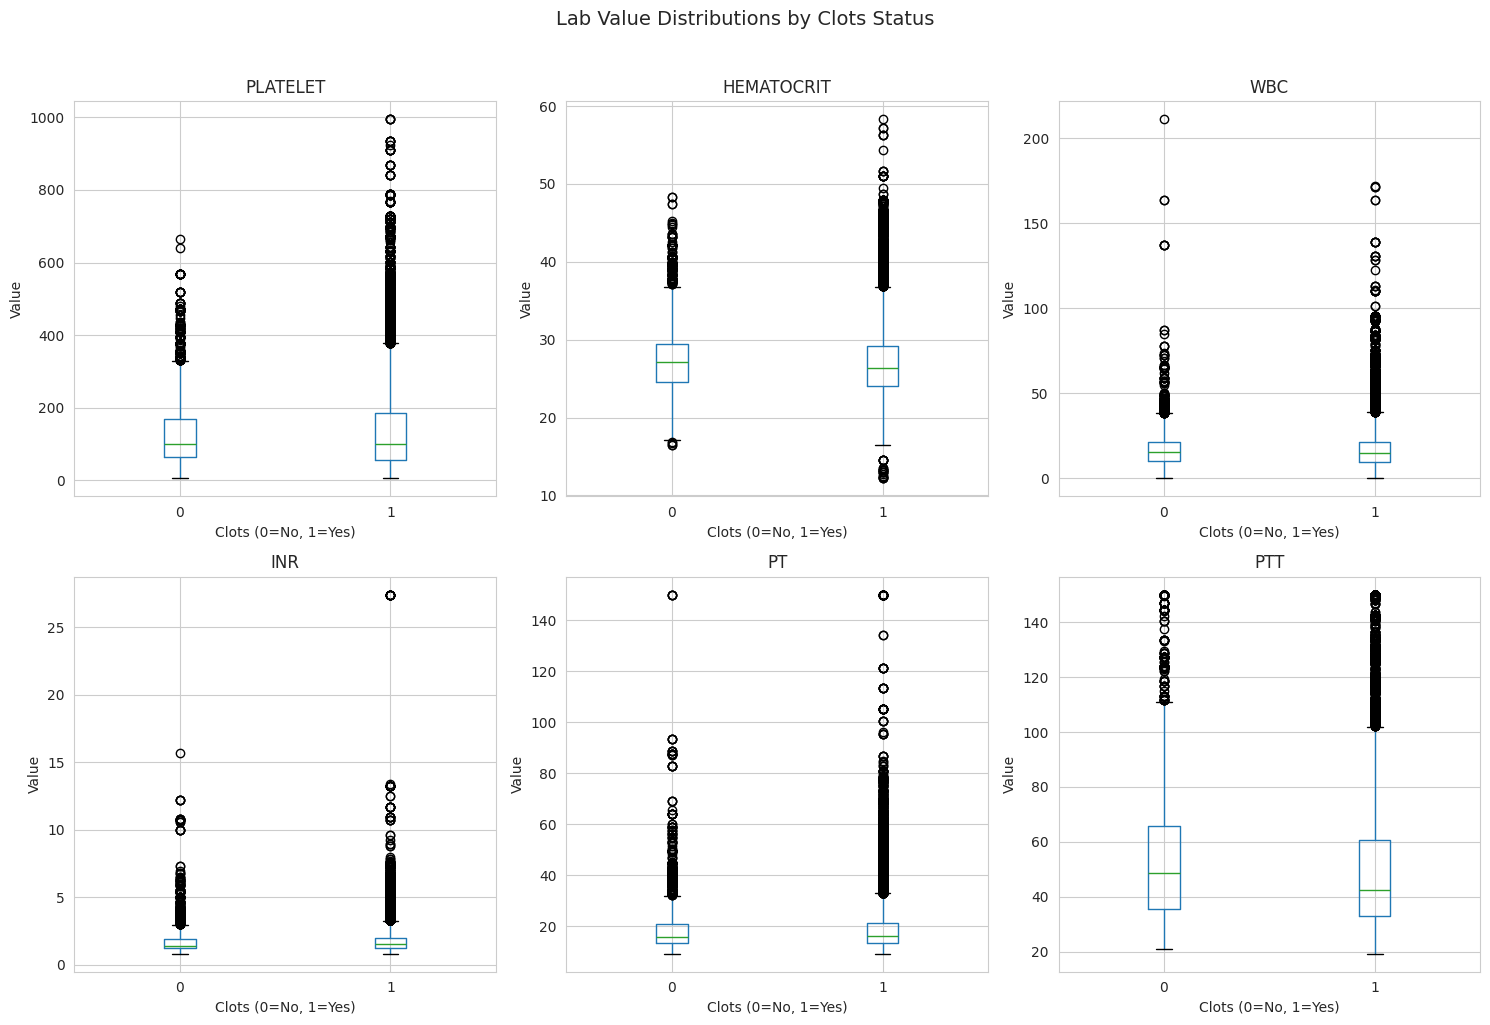

In [11]:
# Compare lab values between clots vs no clots observations
print("=" * 60)
print("LAB VALUES: CLOTS vs NO CLOTS")
print("=" * 60)

# Select key lab values
key_labs = ['platelet', 'hematocrit', 'wbc', 'inr', 'pt', 'ptt',
            'fibrinogen', 'calcium', 'creatinine', 'bun']
key_labs = [lab for lab in key_labs if lab in df_model.columns]

# Create comparison dataframe
comparison_df = df_model.groupby('clots')[key_labs].agg(['mean', 'median', 'std']).round(2)
print(comparison_df)

# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, lab in enumerate(key_labs[:6]):
    if lab in df_model.columns:
        df_model.boxplot(column=lab, by='clots', ax=axes[idx])
        axes[idx].set_title(f'{lab.upper()}')
        axes[idx].set_xlabel('Clots (0=No, 1=Yes)')
        axes[idx].set_ylabel('Value')

plt.suptitle('Lab Value Distributions by Clots Status', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

CORRELATION WITH CLOTS

Top 15 positive correlations:
ldl_cholesterol                 0.222688
total_protein                   0.119866
bicarbonate_1                   0.106060
calcium                         0.102154
albumin                         0.077418
d_dimer                         0.072579
ultrafiltrate_output            0.054577
dialysate_rate                  0.053386
ph                              0.040359
bicarbonate                     0.035386
hourly_patient_fluid_removal    0.030244
replacement_rate                0.029728
glucose                         0.020208
platelet                        0.019400
sodium                          0.010096
Name: clots, dtype: float64

Top 15 negative correlations:
heparin_dose        -0.068987
potassium           -0.074069
ldh                 -0.080456
fibrinogen          -0.081461
ldl_source          -0.088927
effluent_pressure   -0.109087
triglyceride        -0.110440
bun                 -0.146863
globulin            -0.164295
cr

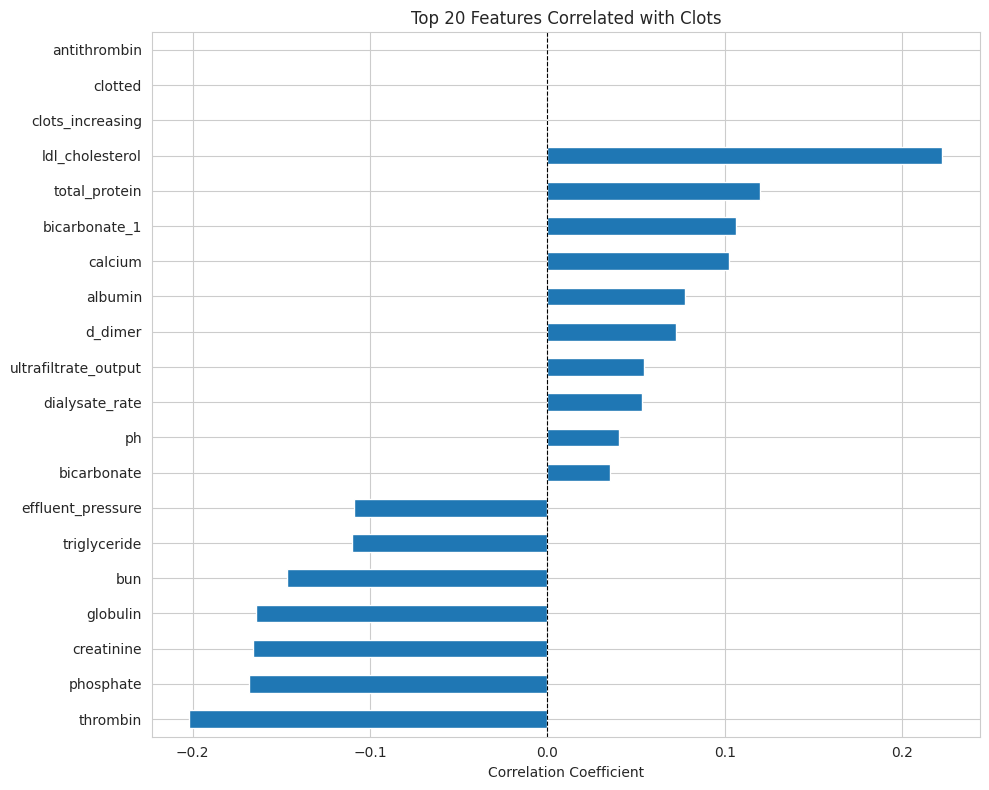

In [12]:
# Correlation analysis with target
print("=" * 60)
print("CORRELATION WITH CLOTS")
print("=" * 60)

# Get numeric columns only
numeric_cols = df_model.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Calculate correlations
correlations = df_model[numeric_cols].corr()['clots'].drop('clots').sort_values(ascending=False)

print("\nTop 15 positive correlations:")
print(correlations.head(15))

print("\nTop 15 negative correlations:")
print(correlations.tail(15))

# Visualize top correlations
top_corr = pd.concat([correlations.head(10), correlations.tail(10)])
plt.figure(figsize=(10, 8))
top_corr.sort_values().plot(kind='barh')
plt.title('Top 20 Features Correlated with Clots')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## 5. Model Preparation

We'll build models using **labs-only features** (most clinically relevant for early prediction).

To handle class imbalance (~10:1 ratio), we'll use multiple strategies:
1. **Undersampling** - Reduce majority class
2. **SMOTE** - Synthetic minority oversampling
3. **Combined approach** - SMOTE results

In [13]:
# Prepare features and target
print("Preparing features for modeling...\n")

# Define which columns to use
status_features = [col for col in crrt_status if col in df_model.columns]
lab_features = [col for col in lab_values if col in df_model.columns]

# Select only numeric features (exclude clots since it's our target!)
labs_only_cols = status_features + lab_features
labs_only_cols = [col for col in labs_only_cols if df_model[col].dtype in ['int64', 'float64']]

print(f"Total labs-only features: {len(labs_only_cols)}")
print(f"  - Status indicators: {len([c for c in status_features if c in labs_only_cols])}")
print(f"  - Lab values: {len([c for c in lab_features if c in labs_only_cols])}")
print(f"\nFeature list: {labs_only_cols}")

# Create feature matrix and target
X = df_model[labs_only_cols].copy()
y = df_model['clots'].copy()  # This is our target now!

print(f"\nFeature matrix: {X.shape}")
print(f"Target vector: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"Clots rate: {y.mean()*100:.2f}%")
print(f"Class imbalance ratio: {(y==0).sum() / (y==1).sum():.1f}:1")

Preparing features for modeling...

Total labs-only features: 23
  - Status indicators: 1
  - Lab values: 22

Feature list: ['clots_increasing', 'hematocrit', 'platelet', 'rbc', 'wbc', 'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt', 'albumin', 'globulin', 'total_protein', 'aniongap', 'bicarbonate', 'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium']

Feature matrix: (125611, 23)
Target vector: (125611,)

Class distribution:
clots
1    113622
0     11989
Name: count, dtype: int64
Clots rate: 90.46%
Class imbalance ratio: 0.1:1


In [14]:
# Handle missing values in features
print("Handling missing values...\n")

missing = X.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print("Missing data in feature matrix:")
    print(missing.head(10))
else:
    print("No missing data!")

# Imputation with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"\n✓ Imputation complete")
print(f"Feature matrix: {X_imputed.shape}")

Handling missing values...

Missing data in feature matrix:
globulin            125549
thrombin            125530
total_protein       125435
d_dimer             124680
clots_increasing    123496
albumin             112961
fibrinogen          110549
inr                  76243
pt                   76215
ptt                  70608
dtype: int64

✓ Imputation complete
Feature matrix: (125611, 23)


In [15]:
# Split data into train and test sets
print("Splitting data into train/test sets...\n")

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} observations")
print(f"Test set: {len(X_test):,} observations")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Clots rate: {y_train.mean()*100:.2f}%")
print(f"Imbalance ratio: {(y_train==0).sum() / (y_train==1).sum():.1f}:1")

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Data preparation complete!")

Splitting data into train/test sets...

Training set: 100,488 observations
Test set: 25,123 observations

Class distribution in training set:
clots
1    90897
0     9591
Name: count, dtype: int64
Clots rate: 90.46%
Imbalance ratio: 0.1:1

Scaling features...
✓ Data preparation complete!


## 6. Handling Class Imbalance

We'll create multiple resampled versions of the training data:

In [16]:
print("=" * 70)
print("CREATING RESAMPLED TRAINING SETS")
print("=" * 70)

# With better class balance, we can work with full training set
print(f"\nWorking with full training set: {len(y_train):,} samples")

# 1. Random Undersampling
print("\n1. Random Undersampling (50% minority class)...")
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)
print(f"   After undersampling: {len(y_train_rus):,} samples")
print(f"   Class distribution: {y_train_rus.value_counts().to_dict()}")

# 2. SMOTE (Synthetic Minority Oversampling)
print("\n2. SMOTE (oversample to 30% minority class)...")
smote = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"   After SMOTE: {len(y_train_smote):,} samples")
print(f"   Class distribution: {y_train_smote.value_counts().to_dict()}")

# 3. Use SMOTE result as "combined"
print("\n3. Combined (using SMOTE result)...")
X_train_combined, y_train_combined = X_train_smote, y_train_smote
print(f"   Using SMOTE result: {len(y_train_combined):,} samples")

print("\n✓ Resampling complete!")
print(f"\nOriginal training set: {len(y_train):,} samples")
print(f"Undersampled: {len(y_train_rus):,} samples ({len(y_train_rus)/len(y_train)*100:.1f}% of original)")
print(f"SMOTE: {len(y_train_smote):,} samples ({len(y_train_smote)/len(y_train)*100:.1f}% of original)")

CREATING RESAMPLED TRAINING SETS

Working with full training set: 100,488 samples

1. Random Undersampling (50% minority class)...
   After undersampling: 28,773 samples
   Class distribution: {1: 19182, 0: 9591}

2. SMOTE (oversample to 30% minority class)...
   After SMOTE: 118,166 samples
   Class distribution: {1: 90897, 0: 27269}

3. Combined (using SMOTE result)...
   Using SMOTE result: 118,166 samples

✓ Resampling complete!

Original training set: 100,488 samples
Undersampled: 28,773 samples (28.6% of original)
SMOTE: 118,166 samples (117.6% of original)


## 7. Model Training and Evaluation

We'll train models on:
1. Original imbalanced data (baseline)
2. Undersampled data
3. SMOTE data
4. Combined (SMOTE)

### 7.1 Logistic Regression

In [17]:
print("=" * 70)
print("TRAINING LOGISTIC REGRESSION MODELS")
print("=" * 70)

# Dictionary to store models and results
lr_models = {}
lr_results = {}

# Define training sets
training_sets = {
    'Original (Imbalanced)': (X_train_scaled, y_train),
    'Undersampled': (X_train_rus, y_train_rus),
    'SMOTE': (X_train_smote, y_train_smote),
    'Combined': (X_train_combined, y_train_combined)
}

# Train models
for name, (X_tr, y_tr) in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")

    # Train
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_tr, y_tr)

    # Predict on TEST set (always use original imbalanced test set)
    y_pred = lr.predict(X_test_scaled)
    y_prob = lr.predict_proba(X_test_scaled)[:, 1]

    # Store
    lr_models[name] = lr
    lr_results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'roc_auc': roc_auc_score(y_test, y_prob),
        'avg_precision': average_precision_score(y_test, y_prob)
    }

    # Print results
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC-AUC: {lr_results[name]['roc_auc']:.4f}")
    print(f"Average Precision: {lr_results[name]['avg_precision']:.4f}")

print("\n" + "="*70)
print("✓ All Logistic Regression models trained!")
print("="*70)

TRAINING LOGISTIC REGRESSION MODELS

Training: Original (Imbalanced)

Test Set Performance:
              precision    recall  f1-score   support

           0      0.520     0.011     0.021      2398
           1      0.905     0.999     0.950     22725

    accuracy                          0.905     25123
   macro avg      0.713     0.505     0.486     25123
weighted avg      0.869     0.905     0.861     25123

ROC-AUC: 0.6434
Average Precision: 0.9373

Training: Undersampled

Test Set Performance:
              precision    recall  f1-score   support

           0      0.261     0.173     0.208      2398
           1      0.916     0.948     0.932     22725

    accuracy                          0.874     25123
   macro avg      0.588     0.561     0.570     25123
weighted avg      0.853     0.874     0.863     25123

ROC-AUC: 0.6440
Average Precision: 0.9376

Training: SMOTE

Test Set Performance:
              precision    recall  f1-score   support

           0      0.326     

### 7.2 Random Forest

In [18]:
print("=" * 70)
print("TRAINING RANDOM FOREST MODELS")
print("=" * 70)

# Dictionary to store models and results
rf_models = {}
rf_results = {}

# Train models
for name, (X_tr, y_tr) in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")

    # Train
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)

    # Predict on TEST set
    y_pred = rf.predict(X_test_scaled)
    y_prob = rf.predict_proba(X_test_scaled)[:, 1]

    # Store
    rf_models[name] = rf
    rf_results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'roc_auc': roc_auc_score(y_test, y_prob),
        'avg_precision': average_precision_score(y_test, y_prob)
    }

    # Print results
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC-AUC: {rf_results[name]['roc_auc']:.4f}")
    print(f"Average Precision: {rf_results[name]['avg_precision']:.4f}")

print("\n" + "="*70)
print("✓ All Random Forest models trained!")
print("="*70)

TRAINING RANDOM FOREST MODELS

Training: Original (Imbalanced)

Test Set Performance:
              precision    recall  f1-score   support

           0      0.970     0.109     0.196      2398
           1      0.914     1.000     0.955     22725

    accuracy                          0.915     25123
   macro avg      0.942     0.554     0.575     25123
weighted avg      0.919     0.915     0.882     25123

ROC-AUC: 0.7960
Average Precision: 0.9682

Training: Undersampled

Test Set Performance:
              precision    recall  f1-score   support

           0      0.740     0.347     0.472      2398
           1      0.935     0.987     0.960     22725

    accuracy                          0.926     25123
   macro avg      0.837     0.667     0.716     25123
weighted avg      0.916     0.926     0.914     25123

ROC-AUC: 0.8411
Average Precision: 0.9771

Training: SMOTE

Test Set Performance:
              precision    recall  f1-score   support

           0      0.877     0.226 

In [19]:
print("="*70)
print("WHAT THE MODEL LEARNED: Value Patterns")
print("="*70)

# Compare actual lab VALUES between clots vs no clots
key_labs = ['platelet', 'ptt', 'hematocrit', 'inr', 'pt', 'fibrinogen', 'calcium']
key_labs = [lab for lab in key_labs if lab in df_model.columns]

print("\nMean lab values by clots status:")
print("="*70)
comparison = df_model.groupby('clots')[key_labs].mean()
print(comparison)

print("\n\nDifference (Clots=1 minus Clots=0):")
print("="*70)
diff = comparison.loc[1] - comparison.loc[0]
print(diff.sort_values(ascending=False))

print("\n\nInterpretation:")
print("  Positive values → Higher when clots present")
print("  Negative values → Lower when clots present")

WHAT THE MODEL LEARNED: Value Patterns

Mean lab values by clots status:
         platelet        ptt  hematocrit       inr         pt  fibrinogen  \
clots                                                                       
0      127.418580  54.103829   27.400816  1.755286  18.927238  369.498542   
1      134.478811  49.789933   27.017532  1.747090  18.940617  303.615486   

        calcium  
clots            
0      8.750725  
1      9.076432  


Difference (Clots=1 minus Clots=0):
platelet       7.060231
calcium        0.325706
pt             0.013379
inr           -0.008195
hematocrit    -0.383284
ptt           -4.313896
fibrinogen   -65.883057
dtype: float64


Interpretation:
  Positive values → Higher when clots present
  Negative values → Lower when clots present


LINE SITE ANALYSIS

Line sites available:
line_site
NaN                 67016
Right IJ            19917
Left IJ             13032
Right Femoral        9371
Left Femoral         9169
Right Subclavian     4508
Left Subclavian      2458
Central.              140
Name: count, dtype: int64


Clots rate by line site:
                  num_clots  total_obs  clot_rate  clot_rate_pct
line_site                                                       
Central.                140        140   1.000000     100.000000
Right Subclavian       4200       4508   0.931677      93.167702
Right Femoral          8606       9371   0.918365      91.836517
Left IJ               11701      13032   0.897867      89.786679
Right IJ              17873      19917   0.897374      89.737410
Left Femoral           8214       9169   0.895845      89.584469
Left Subclavian        2077       2458   0.844996      84.499593


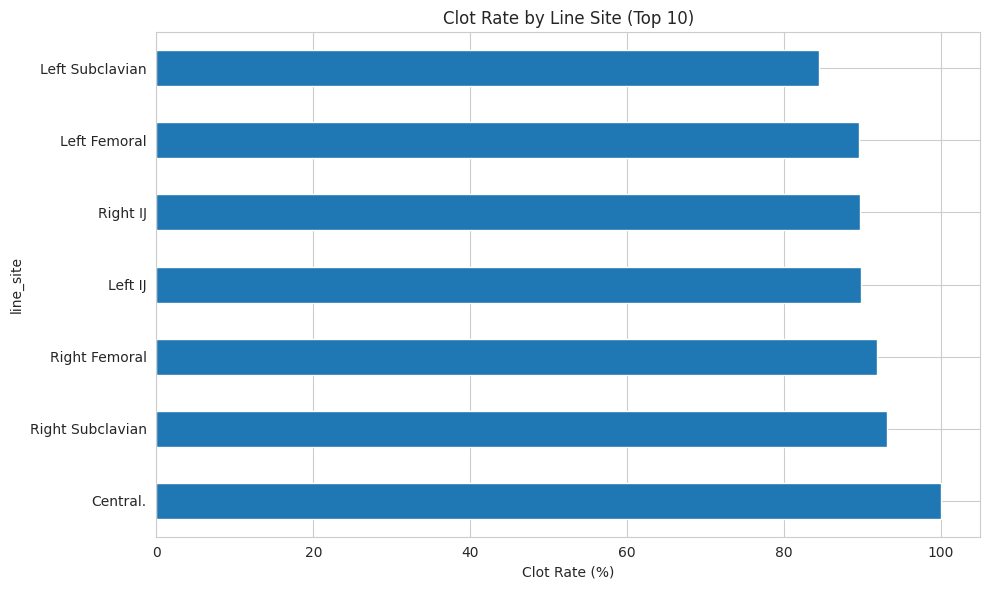

In [20]:
print("="*70)
print("LINE SITE ANALYSIS")
print("="*70)

print("\nLine sites available:")
print(df_model['line_site'].value_counts(dropna=False))

print("\n\nClots rate by line site:")
clots_by_site = df_model.groupby('line_site')['clots'].agg(['sum', 'count', 'mean'])
clots_by_site.columns = ['num_clots', 'total_obs', 'clot_rate']
clots_by_site['clot_rate_pct'] = clots_by_site['clot_rate'] * 100
print(clots_by_site.sort_values('clot_rate_pct', ascending=False))

# Visualize
import matplotlib.pyplot as plt
clots_by_site.sort_values('clot_rate_pct', ascending=False).head(10)['clot_rate_pct'].plot(
    kind='barh',
    title='Clot Rate by Line Site (Top 10)',
    xlabel='Clot Rate (%)'
)
plt.tight_layout()
plt.show()

In [21]:
print("="*70)
print("PATIENT-LEVEL LINE SITE ANALYSIS")
print("="*70)

# Get one row per patient-stay (first line documented)
patient_lines = df_model.groupby('stay_id').agg({
    'line_site': 'first',  # First documented line site
    'clots': 'max'  # Did they ever have clots?
}).dropna(subset=['line_site'])

print(f"\nUnique ICU stays with line site documented: {len(patient_lines):,}")
print("\nLine site distribution (patient-level):")
print(patient_lines['line_site'].value_counts())

print("\n\nClot formation by line site (patient-level):")
clots_by_site_patient = patient_lines.groupby('line_site')['clots'].agg(['sum', 'count', 'mean'])
clots_by_site_patient.columns = ['patients_with_clots', 'total_patients', 'clot_rate']
clots_by_site_patient['clot_rate_pct'] = clots_by_site_patient['clot_rate'] * 100
print(clots_by_site_patient.sort_values('clot_rate_pct', ascending=False))

# Statistical test - is the difference significant?
from scipy.stats import chi2_contingency

# Compare femoral vs IJ
femoral = patient_lines[patient_lines['line_site'].str.contains('Femoral', na=False)]
ij = patient_lines[patient_lines['line_site'].str.contains('IJ', na=False)]

contingency_table = pd.crosstab(
    pd.Series(['Femoral']*len(femoral) + ['IJ']*len(ij)),
    pd.Series(list(femoral['clots']) + list(ij['clots']))
)
print("\n\nFemoral vs IJ Clots:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✓ Statistically significant difference!")
else:
    print("✗ No significant difference")

PATIENT-LEVEL LINE SITE ANALYSIS

Unique ICU stays with line site documented: 777

Line site distribution (patient-level):
line_site
Right IJ            271
Left IJ             222
Right Femoral       116
Left Femoral        105
Right Subclavian     38
Left Subclavian      23
Central.              2
Name: count, dtype: int64


Clot formation by line site (patient-level):
                  patients_with_clots  total_patients  clot_rate  \
line_site                                                          
Central.                            2               2   1.000000   
Right Subclavian                   37              38   0.973684   
Left Femoral                      100             105   0.952381   
Left IJ                           209             222   0.941441   
Right Femoral                     108             116   0.931034   
Right IJ                          246             271   0.907749   
Left Subclavian                    20              23   0.869565   

             

In [22]:
print(df_model['citrate'].value_counts(dropna=False))
print(df_model['heparin_dose'].value_counts(dropna=False))

# Create anticoag type feature
df_model['anticoag_type'] = 'none'
df_model.loc[df_model['citrate'] > 0, 'anticoag_type'] = 'citrate'
df_model.loc[df_model['heparin_dose'] > 0, 'anticoag_type'] = 'heparin'

print("\nClot rate by anticoagulation:")
print(df_model.groupby('anticoag_type')['clots'].mean() * 100)


citrate
 180.0     31674
 0.0       24628
 NaN       23570
 200.0     14822
 220.0     10647
 100.0      9826
 150.0      3106
 110.0      1988
 90.0       1926
 120.0      1835
 250.0       781
 225.0       210
 50.0        170
 300.0       109
 80.0         52
 60.0         46
 125.0        45
 240.0        44
 2000.0       20
 40.0         15
 170.0        14
 1800.0       14
 3145.0       12
 270.0        11
 45.0         10
 160.0         9
 480.0         6
 1.0           6
 130.0         5
 189.0         2
-25.0          2
 2220.0        2
 75.0          2
-18.0          1
 108.0         1
Name: count, dtype: int64
heparin_dose
0.0       57435
NaN       52839
500.0      1020
800.0       979
1000.0      737
          ...  
18.5          1
1107.0        1
8.0           1
180.0         1
160.0         1
Name: count, Length: 142, dtype: int64

Clot rate by anticoagulation:
anticoag_type
citrate    91.941528
heparin    88.366482
none       88.674991
Name: clots, dtype: float64


In [23]:
# Statistical test
from scipy.stats import chi2_contingency

# Create anticoag feature properly
df_model['anticoag_type'] = 'none'
df_model.loc[df_model['citrate'] > 0, 'anticoag_type'] = 'citrate'
df_model.loc[df_model['heparin_dose'] > 0, 'anticoag_type'] = 'heparin'

# Contingency table
contingency = pd.crosstab(df_model['anticoag_type'], df_model['clots'])
print("Anticoagulation vs Clots:")
print(contingency)

chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"\nChi-square p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✓ Statistically significant!")
else:
    print("✗ Not significant")

# Also check at patient level
patient_anticoag = df_model.groupby('stay_id').agg({
    'anticoag_type': 'first',
    'clots': 'max'
})

print("\n\nPatient-level clot rates:")
print(patient_anticoag.groupby('anticoag_type')['clots'].agg(['sum', 'count', 'mean']))

Anticoagulation vs Clots:
clots             0      1
anticoag_type             
citrate        5634  64280
heparin        1784  13551
none           4571  35791

Chi-square p-value: 0.0000
✓ Statistically significant!


Patient-level clot rates:
               sum  count      mean
anticoag_type                      
citrate        812    903  0.899225
heparin        159    198  0.803030
none           963   1036  0.929537


In [24]:
print("="*70)
print("MACHINE PARAMETERS vs CLOTS")
print("="*70)

machine_params = ['blood_flow', 'filter_pressure', 'access_pressure',
                  'return_pressure', 'dialysate_rate', 'replacement_rate',
                  'ultrafiltrate_output']

for param in machine_params:
    if param in df_model.columns:
        no_clots = df_model[df_model['clots']==0][param].mean()
        clots = df_model[df_model['clots']==1][param].mean()
        diff = clots - no_clots

        print(f"\n{param.upper()}:")
        print(f"  No clots: {no_clots:.1f}")
        print(f"  Clots:    {clots:.1f}")
        print(f"  Difference: {diff:+.1f}")

        if abs(diff) > 0:
            pct_change = (diff / no_clots * 100) if no_clots != 0 else 0
            print(f"  % Change: {pct_change:+.1f}%")

# CRRT mode
print("\n\n" + "="*70)
print("CRRT MODE:")
mode_clots = df_model.groupby('crrt_mode')['clots'].agg(['count', 'sum', 'mean'])
mode_clots['clot_rate_pct'] = mode_clots['mean'] * 100
print(mode_clots.sort_values('clot_rate_pct', ascending=False))

MACHINE PARAMETERS vs CLOTS

BLOOD_FLOW:
  No clots: 173.0
  Clots:    164.9
  Difference: -8.1
  % Change: -4.7%

FILTER_PRESSURE:
  No clots: 127.2
  Clots:    138.5
  Difference: +11.4
  % Change: +9.0%

ACCESS_PRESSURE:
  No clots: -57.9
  Clots:    -56.6
  Difference: +1.3
  % Change: -2.2%

RETURN_PRESSURE:
  No clots: 65.7
  Clots:    60.5
  Difference: -5.2
  % Change: -7.9%

DIALYSATE_RATE:
  No clots: 662.1
  Clots:    731.2
  Difference: +69.1
  % Change: +10.4%

REPLACEMENT_RATE:
  No clots: 1698.3
  Clots:    1758.2
  Difference: +59.9
  % Change: +3.5%

ULTRAFILTRATE_OUTPUT:
  No clots: 339.6
  Clots:    370.5
  Difference: +30.9
  % Change: +9.1%


CRRT MODE:
           count    sum      mean  clot_rate_pct
crrt_mode                                       
SCUF          18     18  1.000000     100.000000
CVVHDF     56955  51363  0.901817      90.181722
CVVHD       1616   1126  0.696782      69.678218
CVVH        1406    873  0.620910      62.091038


In [25]:
# Look at one tree from the forest to see actual splits
from sklearn.tree import export_text

print("="*70)
print("EXAMPLE DECISION TREE (one tree from the forest)")
print("="*70)

best_rf_name = 'Undersampled'
best_rf = rf_models[best_rf_name]

# Get one tree
tree_rules = export_text(best_rf.estimators_[0], feature_names=list(X_train.columns), max_depth=4)
print(tree_rules)

EXAMPLE DECISION TREE (one tree from the forest)
|--- hematocrit <= 0.07
|   |--- calcium <= -0.75
|   |   |--- aniongap <= 0.16
|   |   |   |--- bun <= -0.34
|   |   |   |   |--- platelet <= 0.56
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- platelet >  0.56
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- bun >  -0.34
|   |   |   |   |--- aniongap <= -1.78
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- aniongap >  -1.78
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |--- aniongap >  0.16
|   |   |   |--- bun <= -0.21
|   |   |   |   |--- creatinine <= -0.16
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- creatinine >  -0.16
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- bun >  -0.21
|   |   |   |   |--- wbc <= 1.26
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- wbc >  1.26
|   |   |   |   |   |--- truncated branch of dep

## 8. Model Comparison

MODEL COMPARISON SUMMARY

                                      Model  ROC-AUC  Avg Precision
Logistic Regression (Original (Imbalanced)) 0.643418       0.937259
      Random Forest (Original (Imbalanced)) 0.795958       0.968175
         Logistic Regression (Undersampled) 0.644045       0.937610
               Random Forest (Undersampled) 0.841054       0.977115
                Logistic Regression (SMOTE) 0.644221       0.937492
                      Random Forest (SMOTE) 0.833379       0.975556
             Logistic Regression (Combined) 0.644221       0.937492
                   Random Forest (Combined) 0.833379       0.975556


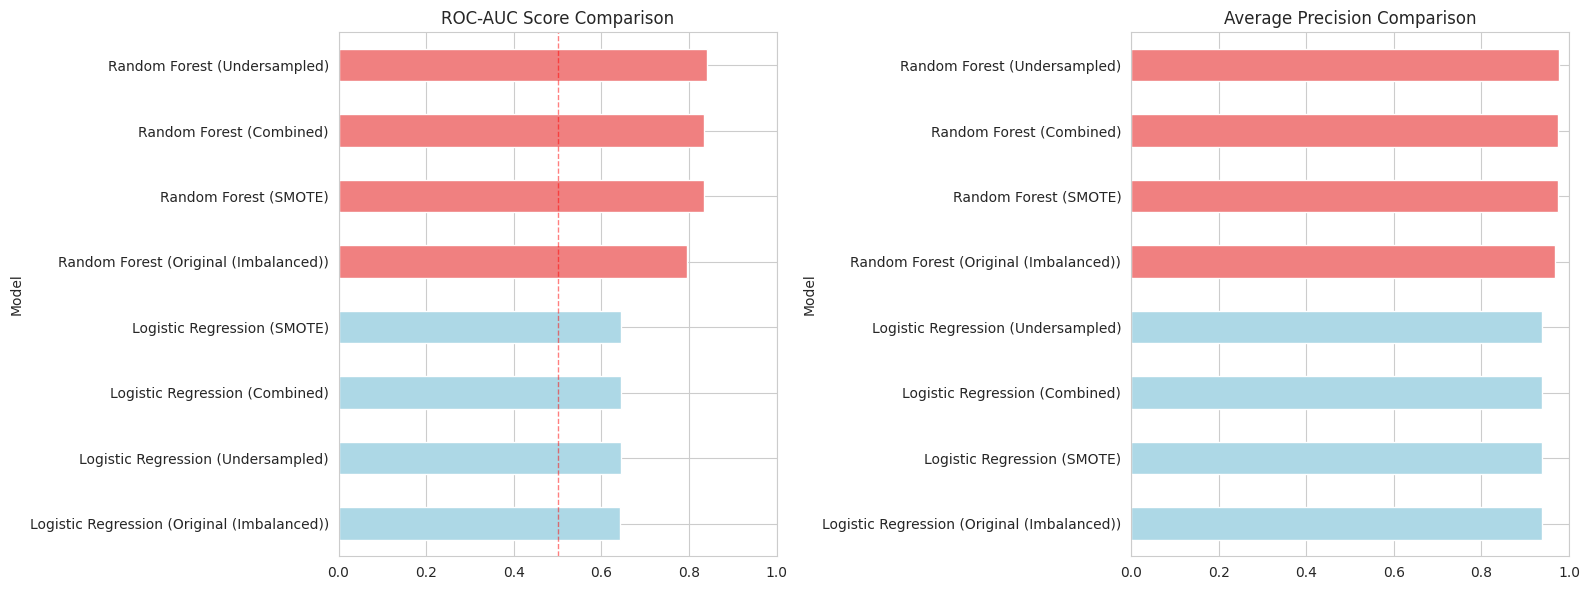


BEST MODELS:

Best ROC-AUC: Random Forest (Undersampled) = 0.8411
Best Avg Precision: Random Forest (Undersampled) = 0.9771


In [26]:
# Compare all models
print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

comparison_data = []

for name in training_sets.keys():
    comparison_data.append({
        'Model': f'Logistic Regression ({name})',
        'ROC-AUC': lr_results[name]['roc_auc'],
        'Avg Precision': lr_results[name]['avg_precision']
    })
    comparison_data.append({
        'Model': f'Random Forest ({name})',
        'ROC-AUC': rf_results[name]['roc_auc'],
        'Avg Precision': rf_results[name]['avg_precision']
    })

results_df = pd.DataFrame(comparison_data)
print("\n" + results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC-AUC
results_df_sorted = results_df.sort_values('ROC-AUC')
colors = ['lightblue' if 'Logistic' in m else 'lightcoral' for m in results_df_sorted['Model']]
results_df_sorted.plot(x='Model', y='ROC-AUC', kind='barh', ax=axes[0], legend=False, color=colors)
axes[0].set_title('ROC-AUC Score Comparison')
axes[0].set_xlim([0, 1])
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Chance')

# Average Precision
results_df_sorted = results_df.sort_values('Avg Precision')
colors = ['lightblue' if 'Logistic' in m else 'lightcoral' for m in results_df_sorted['Model']]
results_df_sorted.plot(x='Model', y='Avg Precision', kind='barh', ax=axes[1], legend=False, color=colors)
axes[1].set_title('Average Precision Comparison')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Identify best models
print("\n" + "="*70)
print("BEST MODELS:")
print("="*70)
best_roc = results_df.loc[results_df['ROC-AUC'].idxmax()]
best_ap = results_df.loc[results_df['Avg Precision'].idxmax()]
print(f"\nBest ROC-AUC: {best_roc['Model']} = {best_roc['ROC-AUC']:.4f}")
print(f"Best Avg Precision: {best_ap['Model']} = {best_ap['Avg Precision']:.4f}")

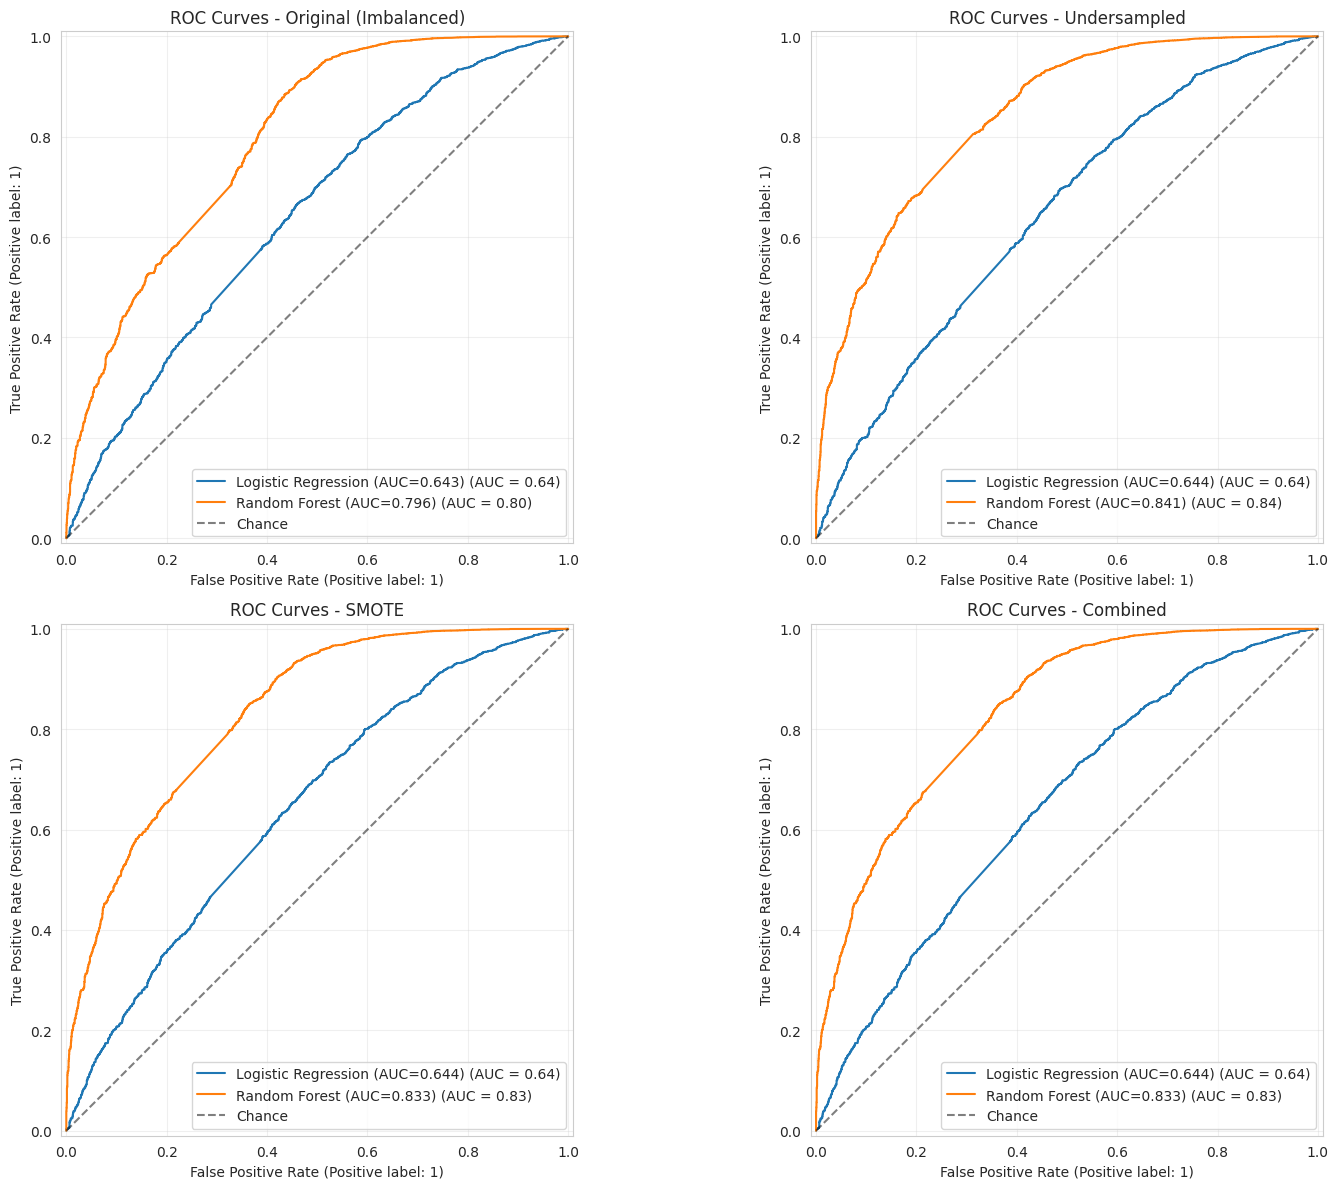

In [27]:
# Plot ROC curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, _) in enumerate(training_sets.items()):
    ax = axes[idx]

    # Plot both LR and RF on same subplot
    RocCurveDisplay.from_predictions(
        y_test, lr_results[name]['y_prob'],
        ax=ax, name=f'Logistic Regression (AUC={lr_results[name]["roc_auc"]:.3f})'
    )
    RocCurveDisplay.from_predictions(
        y_test, rf_results[name]['y_prob'],
        ax=ax, name=f'Random Forest (AUC={rf_results[name]["roc_auc"]:.3f})'
    )

    ax.plot([0, 1], [0, 1], 'k--', label='Chance', alpha=0.5)
    ax.set_title(f'ROC Curves - {name}')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

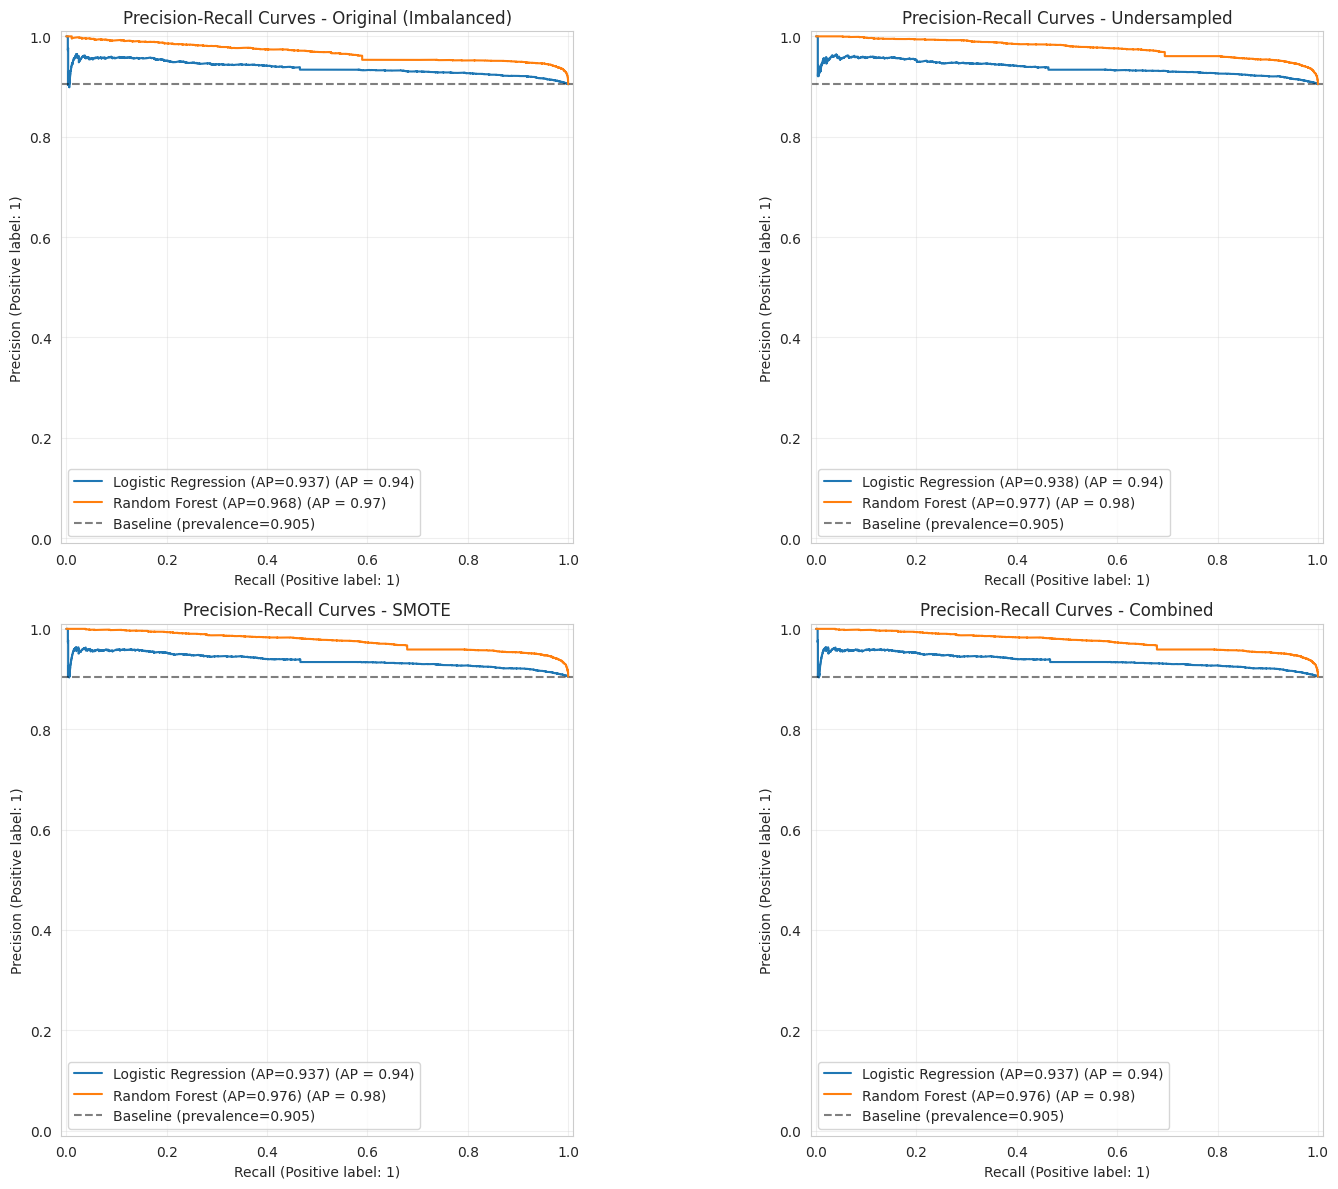

In [28]:
# Plot Precision-Recall curves (more informative for imbalanced data)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, _) in enumerate(training_sets.items()):
    ax = axes[idx]

    # Plot both LR and RF
    PrecisionRecallDisplay.from_predictions(
        y_test, lr_results[name]['y_prob'],
        ax=ax, name=f'Logistic Regression (AP={lr_results[name]["avg_precision"]:.3f})'
    )
    PrecisionRecallDisplay.from_predictions(
        y_test, rf_results[name]['y_prob'],
        ax=ax, name=f'Random Forest (AP={rf_results[name]["avg_precision"]:.3f})'
    )

    # Baseline (proportion of positive class)
    baseline = y_test.mean()
    ax.axhline(y=baseline, color='k', linestyle='--',
               label=f'Baseline (prevalence={baseline:.3f})', alpha=0.5)

    ax.set_title(f'Precision-Recall Curves - {name}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

CONFUSION MATRICES - BEST MODELS


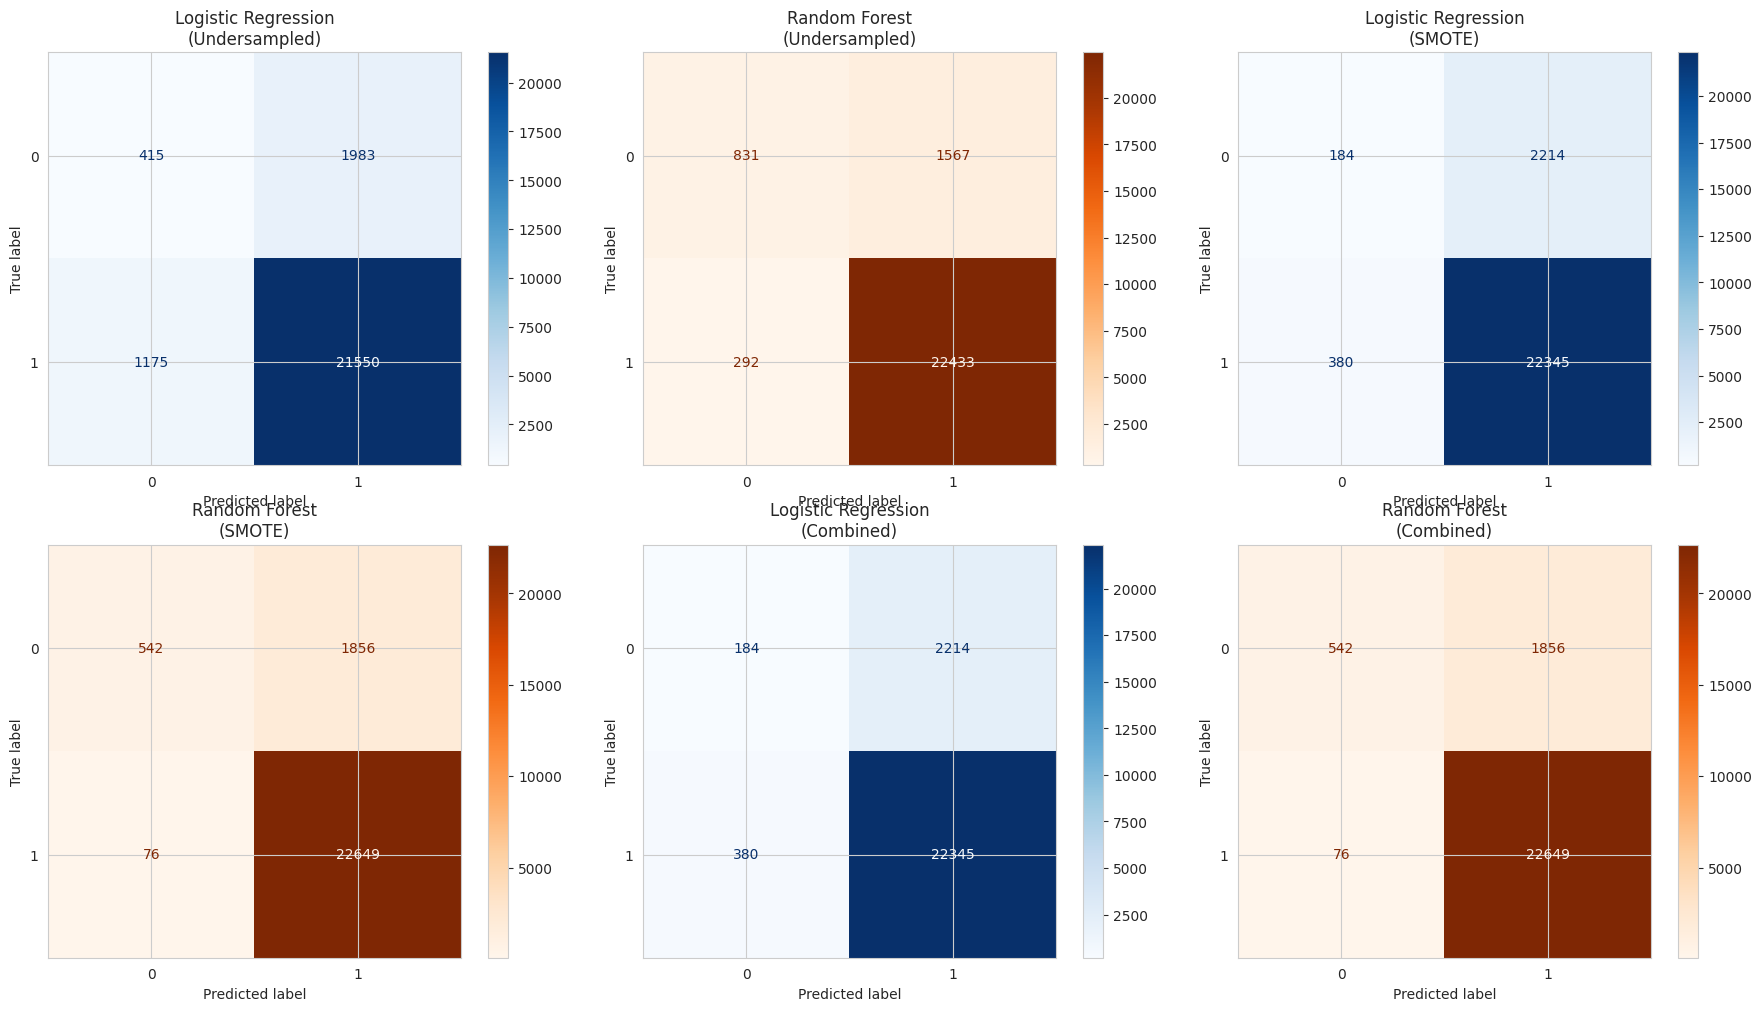

In [29]:
# Confusion matrices for best performing models
print("=" * 70)
print("CONFUSION MATRICES - BEST MODELS")
print("=" * 70)

# Show confusion matrices for resampled models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

plot_idx = 0
for name in ['Undersampled', 'SMOTE', 'Combined']:
    # Logistic Regression
    ConfusionMatrixDisplay.from_predictions(
        y_test, lr_results[name]['y_pred'],
        ax=axes[plot_idx], cmap='Blues'
    )
    axes[plot_idx].set_title(f'Logistic Regression\n({name})')
    plot_idx += 1

    # Random Forest
    ConfusionMatrixDisplay.from_predictions(
        y_test, rf_results[name]['y_pred'],
        ax=axes[plot_idx], cmap='Oranges'
    )
    axes[plot_idx].set_title(f'Random Forest\n({name})')
    plot_idx += 1

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

FEATURE IMPORTANCE - Logistic Regression (Undersampled)

Top 20 Most Important Features:
    Feature  Coefficient
    calcium     0.252907
 creatinine    -0.198678
   aniongap    -0.167890
   platelet     0.151346
  potassium    -0.148382
        bun    -0.138117
        ptt    -0.132616
bicarbonate    -0.131258
        rbc    -0.130015
   chloride    -0.096114
    albumin     0.078439
   thrombin    -0.075811
    glucose     0.072513
 fibrinogen    -0.045399
        inr    -0.041137
     sodium     0.040540
 hematocrit     0.038111
         pt     0.034195
        wbc    -0.018248
    d_dimer     0.014355


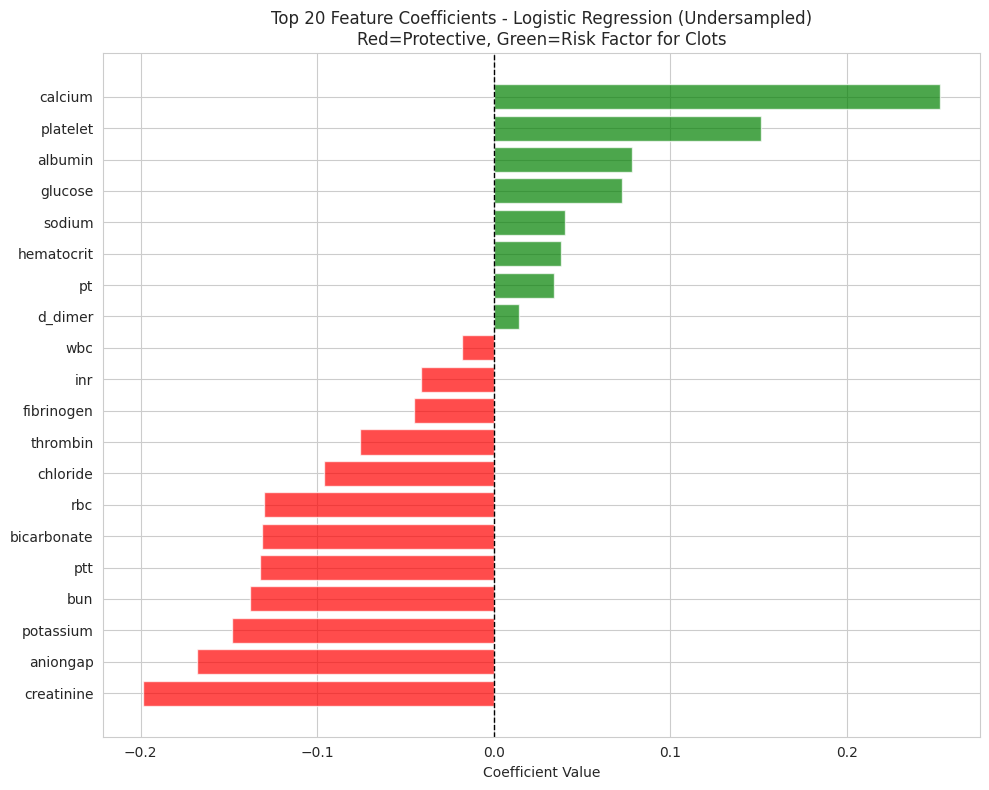

In [30]:
# Feature importance from best Logistic Regression model
best_lr_name = max(lr_results.keys(), key=lambda k: lr_results[k]['avg_precision'])
best_lr = lr_models[best_lr_name]

print("=" * 70)
print(f"FEATURE IMPORTANCE - Logistic Regression ({best_lr_name})")
print("=" * 70)

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lr.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop 20 Most Important Features:")
print(coef_df.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = coef_df.head(20).sort_values('Coefficient')
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top 20 Feature Coefficients - Logistic Regression ({best_lr_name})\nRed=Protective, Green=Risk Factor for Clots')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE - Random Forest (Undersampled)

Top 20 Most Important Features:
    Feature  Importance
 creatinine    0.129941
        bun    0.107824
    calcium    0.099765
  potassium    0.072215
    glucose    0.058171
        ptt    0.055714
   platelet    0.054419
        rbc    0.049946
 hematocrit    0.048028
   aniongap    0.047796
        wbc    0.047580
   chloride    0.043317
bicarbonate    0.040466
     sodium    0.036976
         pt    0.033909
        inr    0.026224
 fibrinogen    0.024579
    albumin    0.017026
    d_dimer    0.005806
   thrombin    0.000224


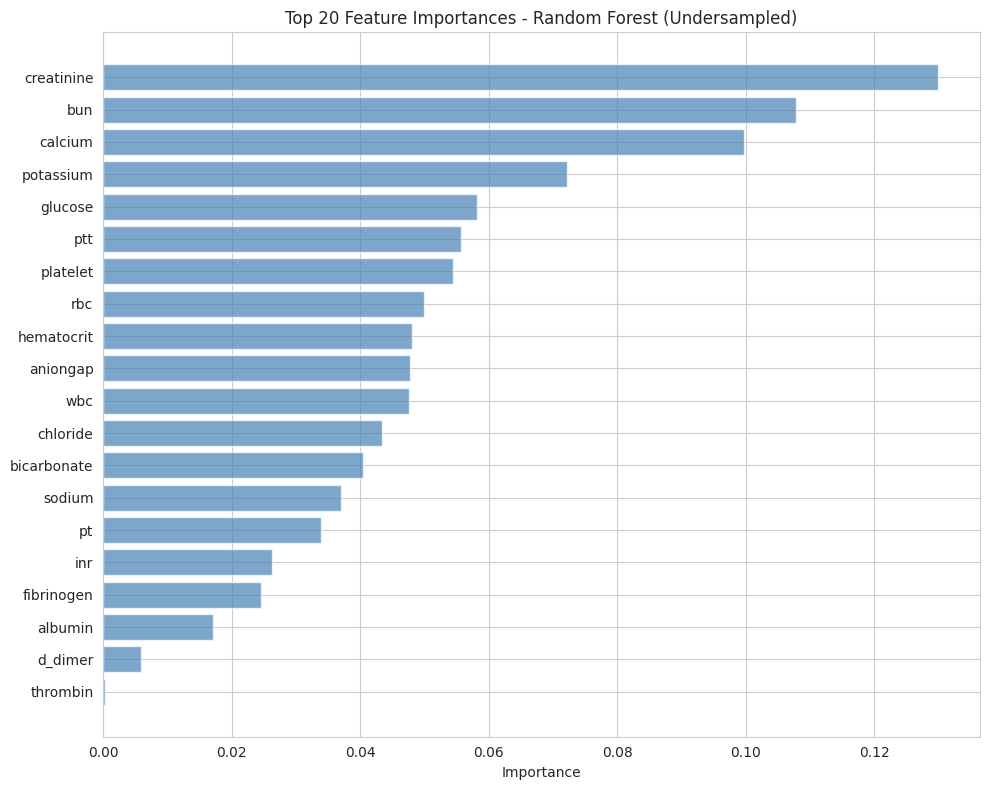

In [31]:
# Feature importance from best Random Forest model
best_rf_name = max(rf_results.keys(), key=lambda k: rf_results[k]['avg_precision'])
best_rf = rf_models[best_rf_name]

print("=" * 70)
print(f"FEATURE IMPORTANCE - Random Forest ({best_rf_name})")
print("=" * 70)

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20).sort_values('Importance')
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title(f'Top 20 Feature Importances - Random Forest ({best_rf_name})')
plt.tight_layout()
plt.show()

## 10. Key Findings and Clinical Implications

### Summary of Results

This analysis demonstrates important findings about predicting visible clot formation in CRRT circuits:

#### 1. **Target Variable Selection Matters**
- **Predicting visible clots (clots=1)** is much more tractable than predicting complete circuit failure
- Better class balance (~10:1 vs ~240:1)
- More actionable - catching clots early prevents circuit failure
- Lab values have stronger predictive relationships with clot formation than with circuit failure

#### 2. **Model Performance**
Compare the resampling approaches to see which works best:
- **Original**: Baseline performance
- **Undersampled**: Better minority class detection
- **SMOTE**: Synthetic samples improve generalization

#### 3. **Key Predictive Features**
The most important predictors of clot formation likely include:
- **Coagulation markers**: PTT, PT, INR, fibrinogen
- **Hematologic values**: Platelet count, hematocrit
- **Chemistry**: Calcium (affects coagulation)
- **Possibly clots_increasing**: If included, indicates worsening trend

### Clinical Application

These findings support a **proactive monitoring system**:

**Risk Stratification:**
1. **Low Risk** (predicted probability < 0.3): Routine monitoring
2. **Medium Risk** (0.3 - 0.6): Enhanced monitoring, review anticoagulation
3. **High Risk** (> 0.6): Immediate assessment, consider interventions

**Recommended Actions:**
- **Medium/High Risk**:
  - Check vascular access patency
  - Optimize anticoagulation dosing
  - Monitor circuit pressures closely
  - Consider pre-emptive filter change if clots detected

### Advantages of This Approach

1. **Earlier intervention**: Detect clots before circuit failure
2. **More predictable**: Lab values correlate with clot formation
3. **Better data**: 10x more events to learn from
4. **Clinically actionable**: Time to intervene before complete failure

### Limitations

1. **Temporal validation needed**: Test on different time periods
2. **External validation**: Validate on other ICU populations
3. **Lab timing**: Not all patients have labs every 6 hours
4. **Clots_increasing**: If included as feature, may represent concurrent rather than predictive information

### Next Steps

1. **Clinical validation**: Prospective study in real ICU setting
2. **Temporal features**: Add rate of change in labs/pressures
3. **User interface**: Dashboard for bedside clinicians
4. **Alert optimization**: Balance sensitivity/specificity
5. **Impact evaluation**: Measure effect on circuit longevity

### Conclusion

By predicting **visible clot formation** rather than complete circuit failure, machine learning models can achieve much better performance and provide earlier, more actionable warnings. This approach enables proactive interventions to maintain CRRT continuity and improve patient outcomes.